# builder

```
RM20/0001, RM20/0015, RM20/0020
```

In [ ]:
!pip install fredapi

## Data preparation

In [2]:
import preprocessor as pre
import naiveforecastor as nf
import visualiser as visual
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Import data
elec_df = pre.clean_elec_csv('Data_flat_files/ELECTRICITY_03_2024.csv',2014,2024)
beets_df = pre.get_Fred_data("WPU01130232",2014,2024)
corn_df = pre.get_Fred_data("PMAIZMTUSDM",2014,2024)
ethylene_df = pre.get_Fred_data("WPU07110224",2014,2024)
phosphate_df = pre.get_Fred_data("WPU065202",2014,2024)

df = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2014,2023)

target = 'builder'.lower()
RM_codes = ['RM20/0001', 'RM20/0015', 'RM20/0020']

external_drivers = {
    "Electricity": elec_df,
    "WPU01130232": beets_df,
    "PMAIZMTUSDM": corn_df,
    "WPU07110224": ethylene_df,
    "WPU065202": phosphate_df
}

slicing_columns = ["WPU01130232","PMAIZMTUSDM","WPU07110224","WPU065202","Electricity","AR"]

In [3]:
# Impute raw data of target variables 
imputed_df, missing = pre.impute_pred_price_evo_csv(df)

# Slice date range for Naice Forecast
naive_df = imputed_df[imputed_df.Year >= 2016]
                      
## Feature engineering for Lasso
# Create dummy variables
dummy_df = pre.get_dummies_and_average_price(imputed_df,target,*RM_codes)

# Generate features
target_df = pre.generate_features(1,12,dummy_df,*RM_codes, **external_drivers)

target_df = target_df[target_df.Year >= 2016]
print(target_df.columns)

Index(['RM20/0015', 'RM20/0020', 'Year', 'Month', 'Time', 'Group Description',
       'Average_price', 'Electricity_1', 'WPU01130232_1', 'PMAIZMTUSDM_1',
       'WPU07110224_1', 'WPU065202_1', 'Electricity_2', 'WPU01130232_2',
       'PMAIZMTUSDM_2', 'WPU07110224_2', 'WPU065202_2', 'Electricity_3',
       'WPU01130232_3', 'PMAIZMTUSDM_3', 'WPU07110224_3', 'WPU065202_3',
       'Electricity_4', 'WPU01130232_4', 'PMAIZMTUSDM_4', 'WPU07110224_4',
       'WPU065202_4', 'Electricity_5', 'WPU01130232_5', 'PMAIZMTUSDM_5',
       'WPU07110224_5', 'WPU065202_5', 'Electricity_6', 'WPU01130232_6',
       'PMAIZMTUSDM_6', 'WPU07110224_6', 'WPU065202_6', 'Electricity_7',
       'WPU01130232_7', 'PMAIZMTUSDM_7', 'WPU07110224_7', 'WPU065202_7',
       'Electricity_8', 'WPU01130232_8', 'PMAIZMTUSDM_8', 'WPU07110224_8',
       'WPU065202_8', 'Electricity_9', 'WPU01130232_9', 'PMAIZMTUSDM_9',
       'WPU07110224_9', 'WPU065202_9', 'Electricity_10', 'WPU01130232_10',
       'PMAIZMTUSDM_10', 'WPU07110224

## 1 Month Prediction

### Naive 1-month

MAPE of 1 month(s) builder Naive Forecast: 0.078
MSE of 1 month(s) builder Naive Forecast: 0.035


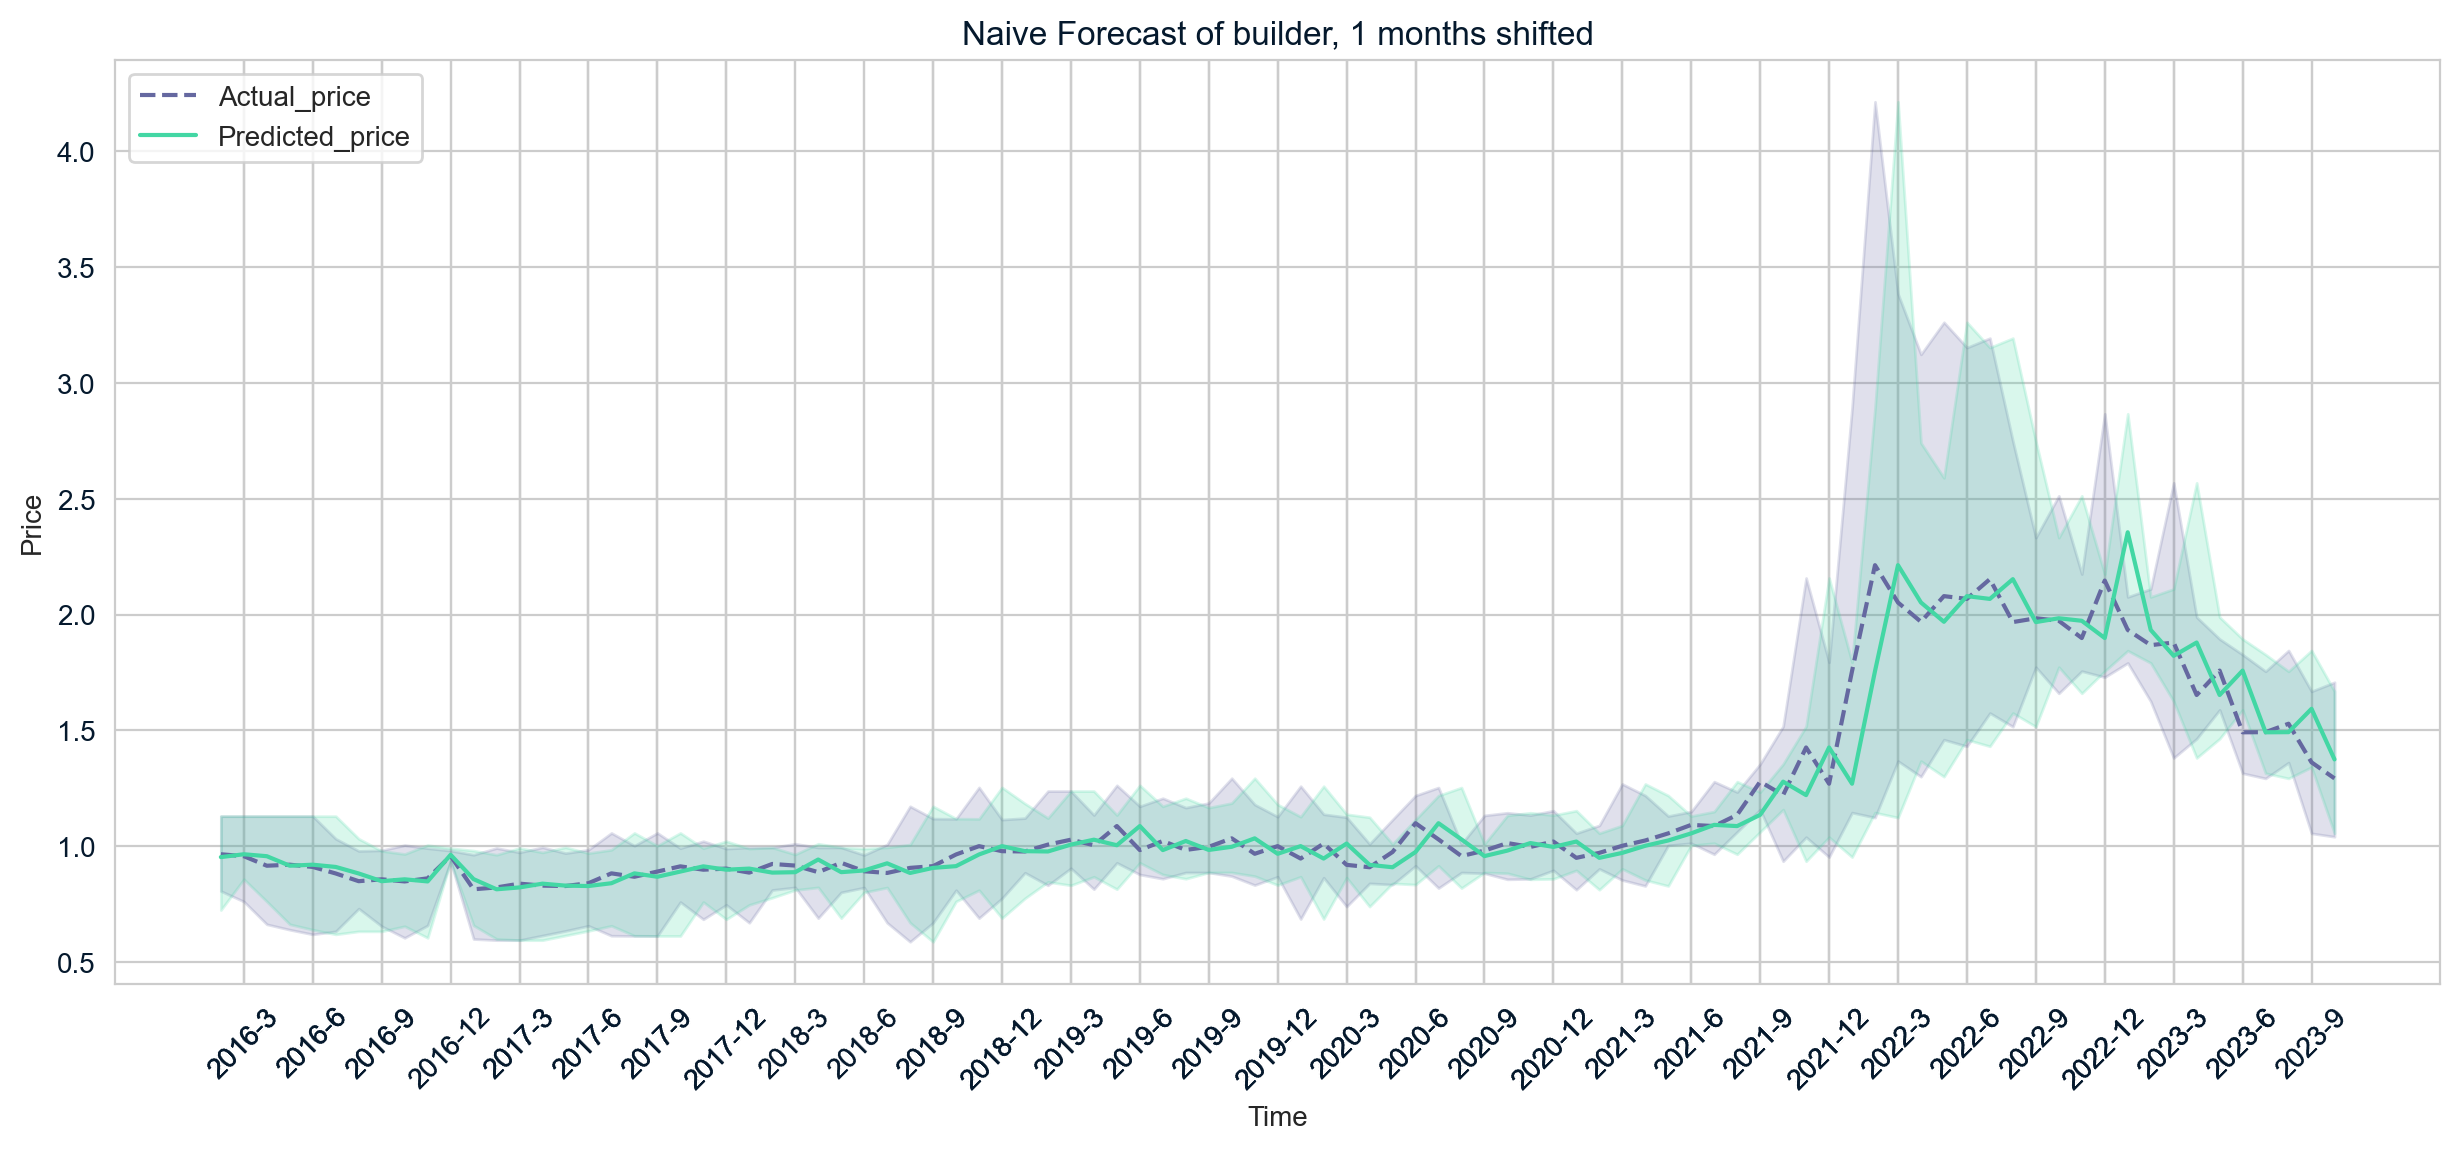

In [4]:
# Naive forecast
nf.naive_forest(naive_df,target,1,missing)


### Lasso 1-month

In [5]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Create X, y
feature_list = target_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = target_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [6]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

print("MAPE, 1-month, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))
print("MSE, 1-month, train: ", round(mean_squared_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 0.01700576685561854
Best R-squared score: 0.904
Coefficients of the selected features in the best Lasso model:
RM20/0015: -0.052
RM20/0020: -0.207
Electricity_1: 0.0
WPU01130232_1: 0.0
PMAIZMTUSDM_1: 0.044
WPU07110224_1: 0.0
WPU065202_1: 0.163
Electricity_2: 0.0
WPU01130232_2: 0.0
PMAIZMTUSDM_2: 0.0
WPU07110224_2: 0.0
WPU065202_2: 0.0
Electricity_3: 0.0
WPU01130232_3: -0.0
PMAIZMTUSDM_3: 0.0
WPU07110224_3: 0.0
WPU065202_3: 0.0
Electricity_4: 0.0
WPU01130232_4: -0.0
PMAIZMTUSDM_4: 0.0
WPU07110224_4: 0.0
WPU065202_4: 0.0
Electricity_5: 0.0
WPU01130232_5: -0.0
PMAIZMTUSDM_5: 0.0
WPU07110224_5: 0.008
WPU065202_5: 0.0
Electricity_6: 0.0
WPU01130232_6: -0.025
PMAIZMTUSDM_6: 0.0
WPU07110224_6: 0.0
WPU065202_6: 0.0
Electricity_7: 0.0
WPU01130232_7: -0.019
PMAIZMTUSDM_7: 0.0
WPU07110224_7: 0.0
WPU065202_7: 0.0
Electricity_8: 0.0
WPU01130232_8: -0.0
PMAIZMTUSDM_8: 0.178
WPU07110224_8: 0.0
WPU065202_8: -0.0
Electricity_9: -0.0
WPU01130232_9: -0.0
PMAIZMTUSDM_9: 0.0
WPU071102

In [7]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 1-month, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

# Best mean_squared_error
print("MSE, 1-month, test: ", round(mean_squared_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.01700576685561854)
Test Set R-squared score: 0.892
MAPE, 1-month, test:  0.08
MSE, 1-month, test:  0.025


In [8]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

df_24 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2014,2024)

imputed_df_24, missing_24 = pre.impute_pred_price_evo_csv(df_24)

dummy_df_24 = pre.get_dummies_and_average_price(imputed_df_24,target,*RM_codes)

target_df_24 = pre.generate_features(1,12,dummy_df_24,*RM_codes,**external_drivers)

# Create X, y
feature_list = target_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list
y_24 = target_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f"MAPE, 1-month, new data: {mape_24:.3f}")
mse_24 = mean_squared_error(y_24,y_pred_24_inverse)
# Best mean_squared_error
print(f"MSE, 1-month, new data: {mse_24:.3f}")

MAPE, 1-month, new data: 0.078
MSE, 1-month, new data: 0.029


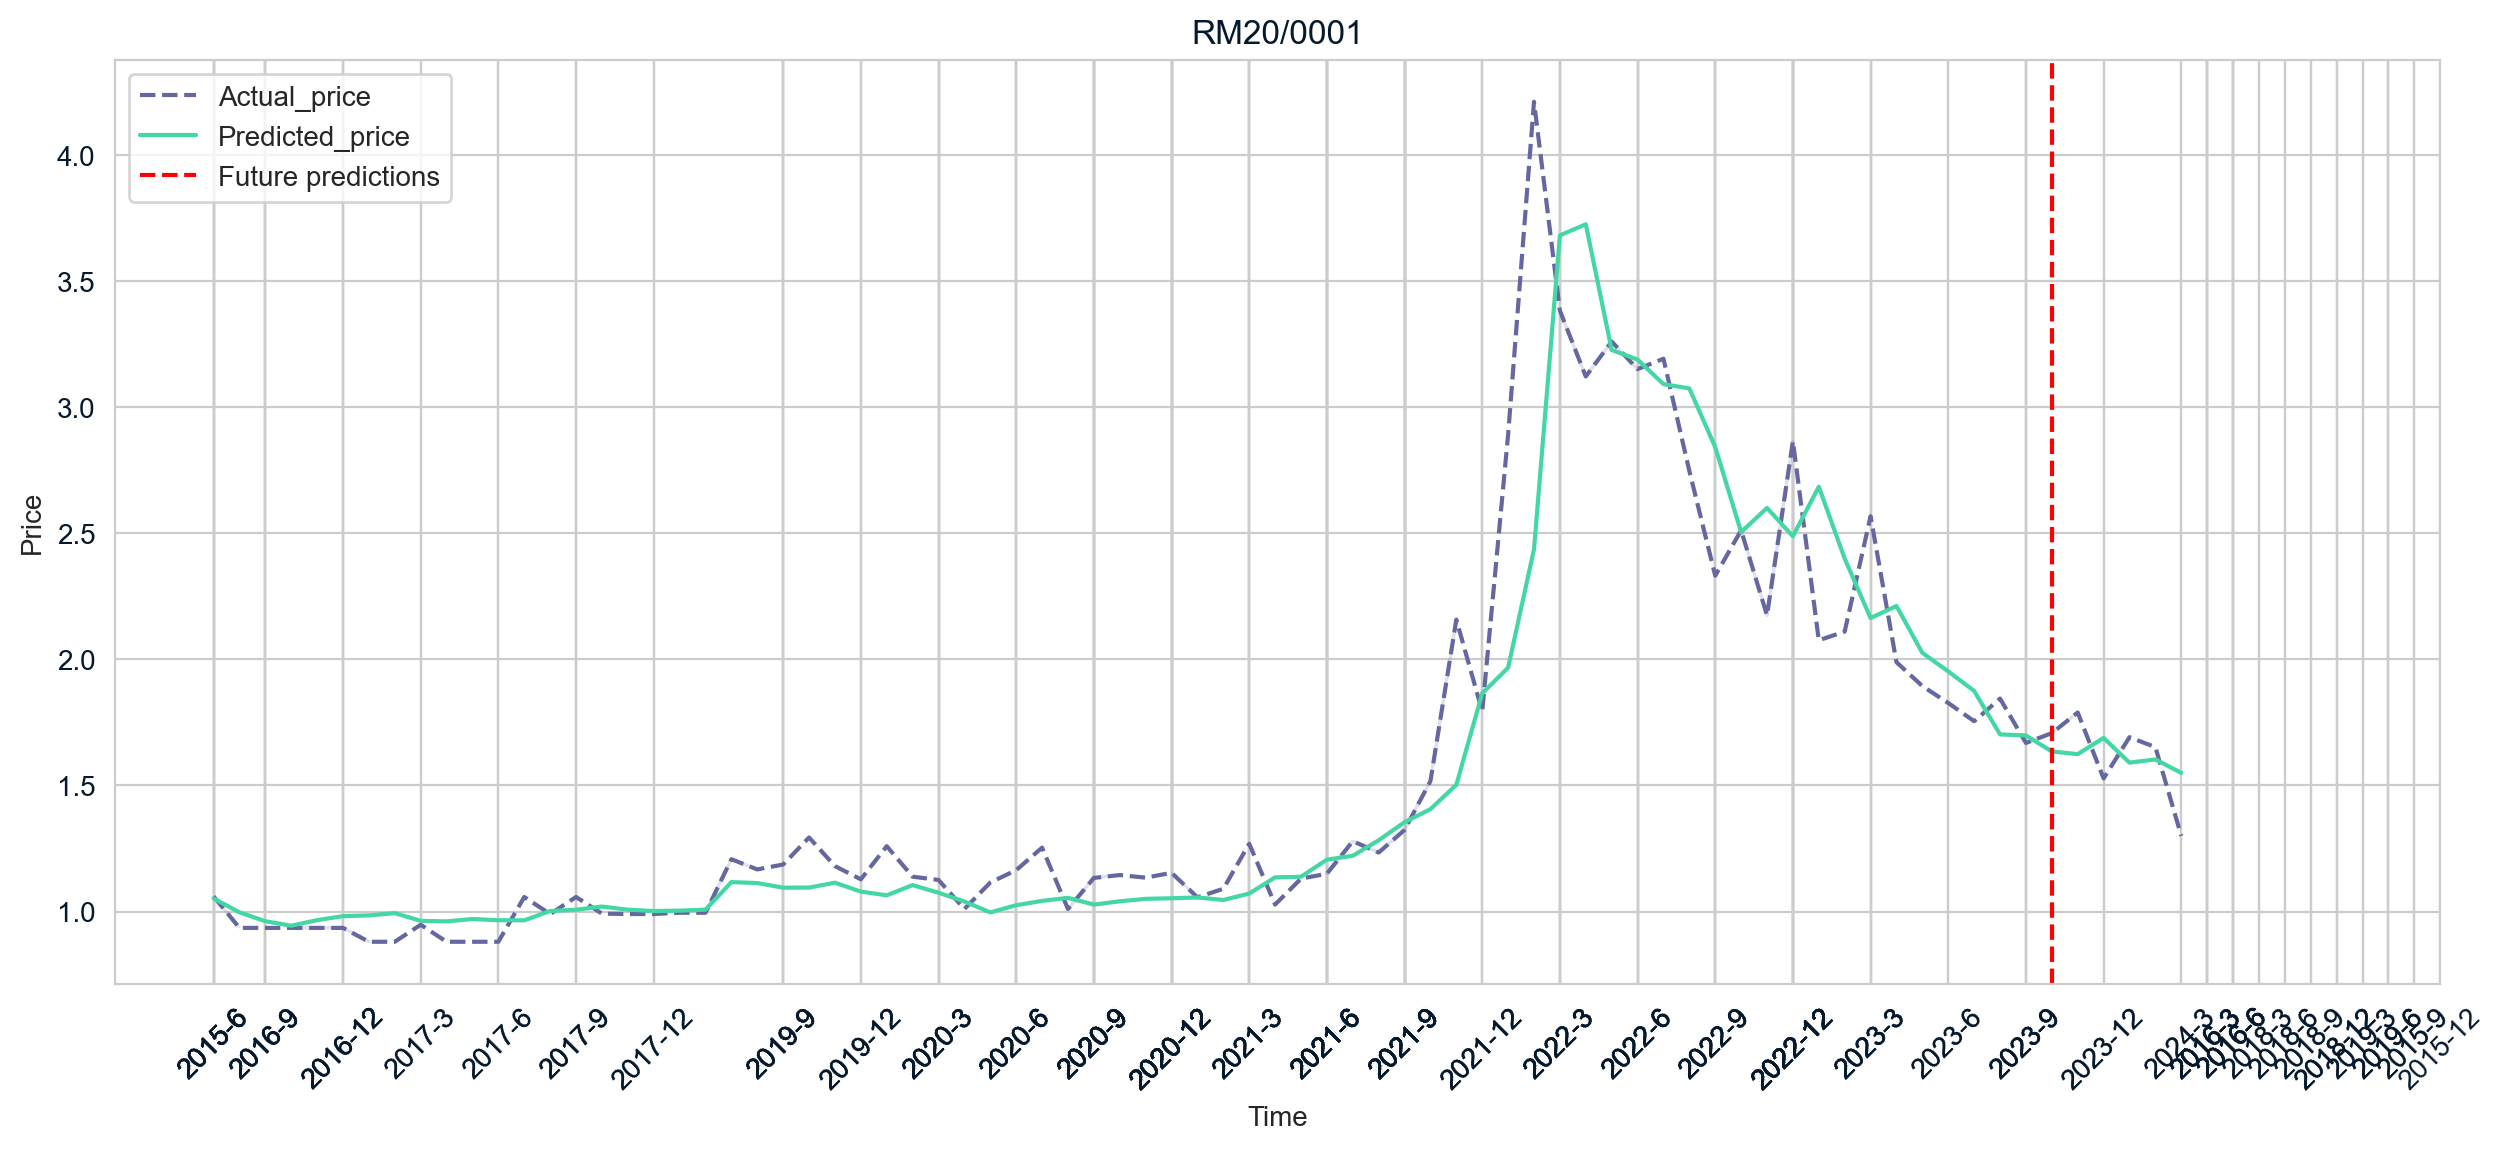

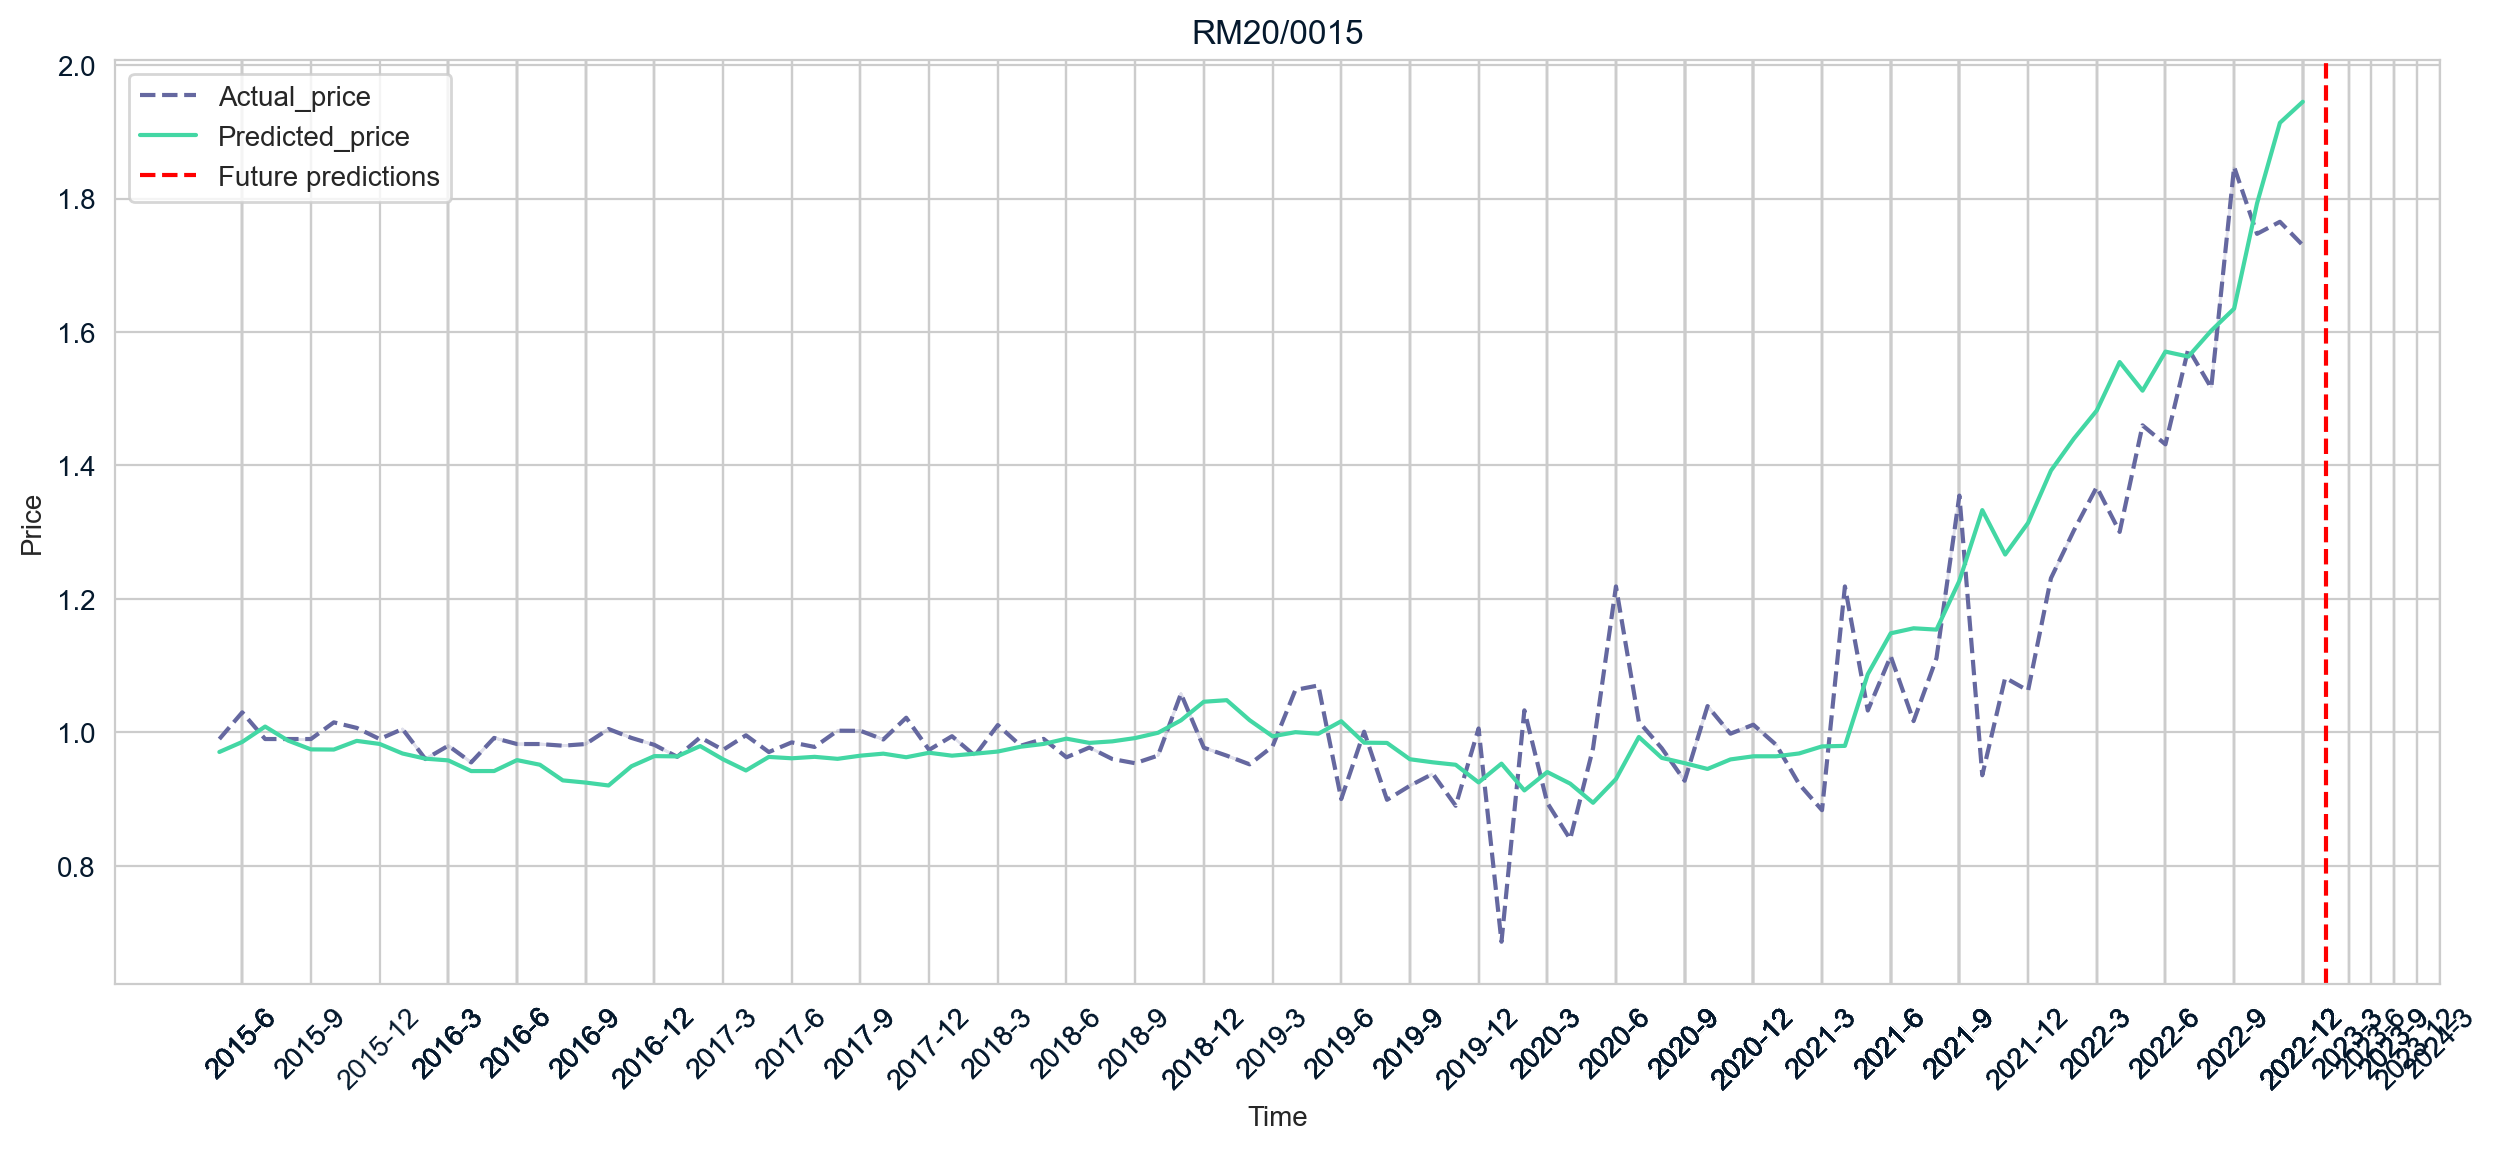

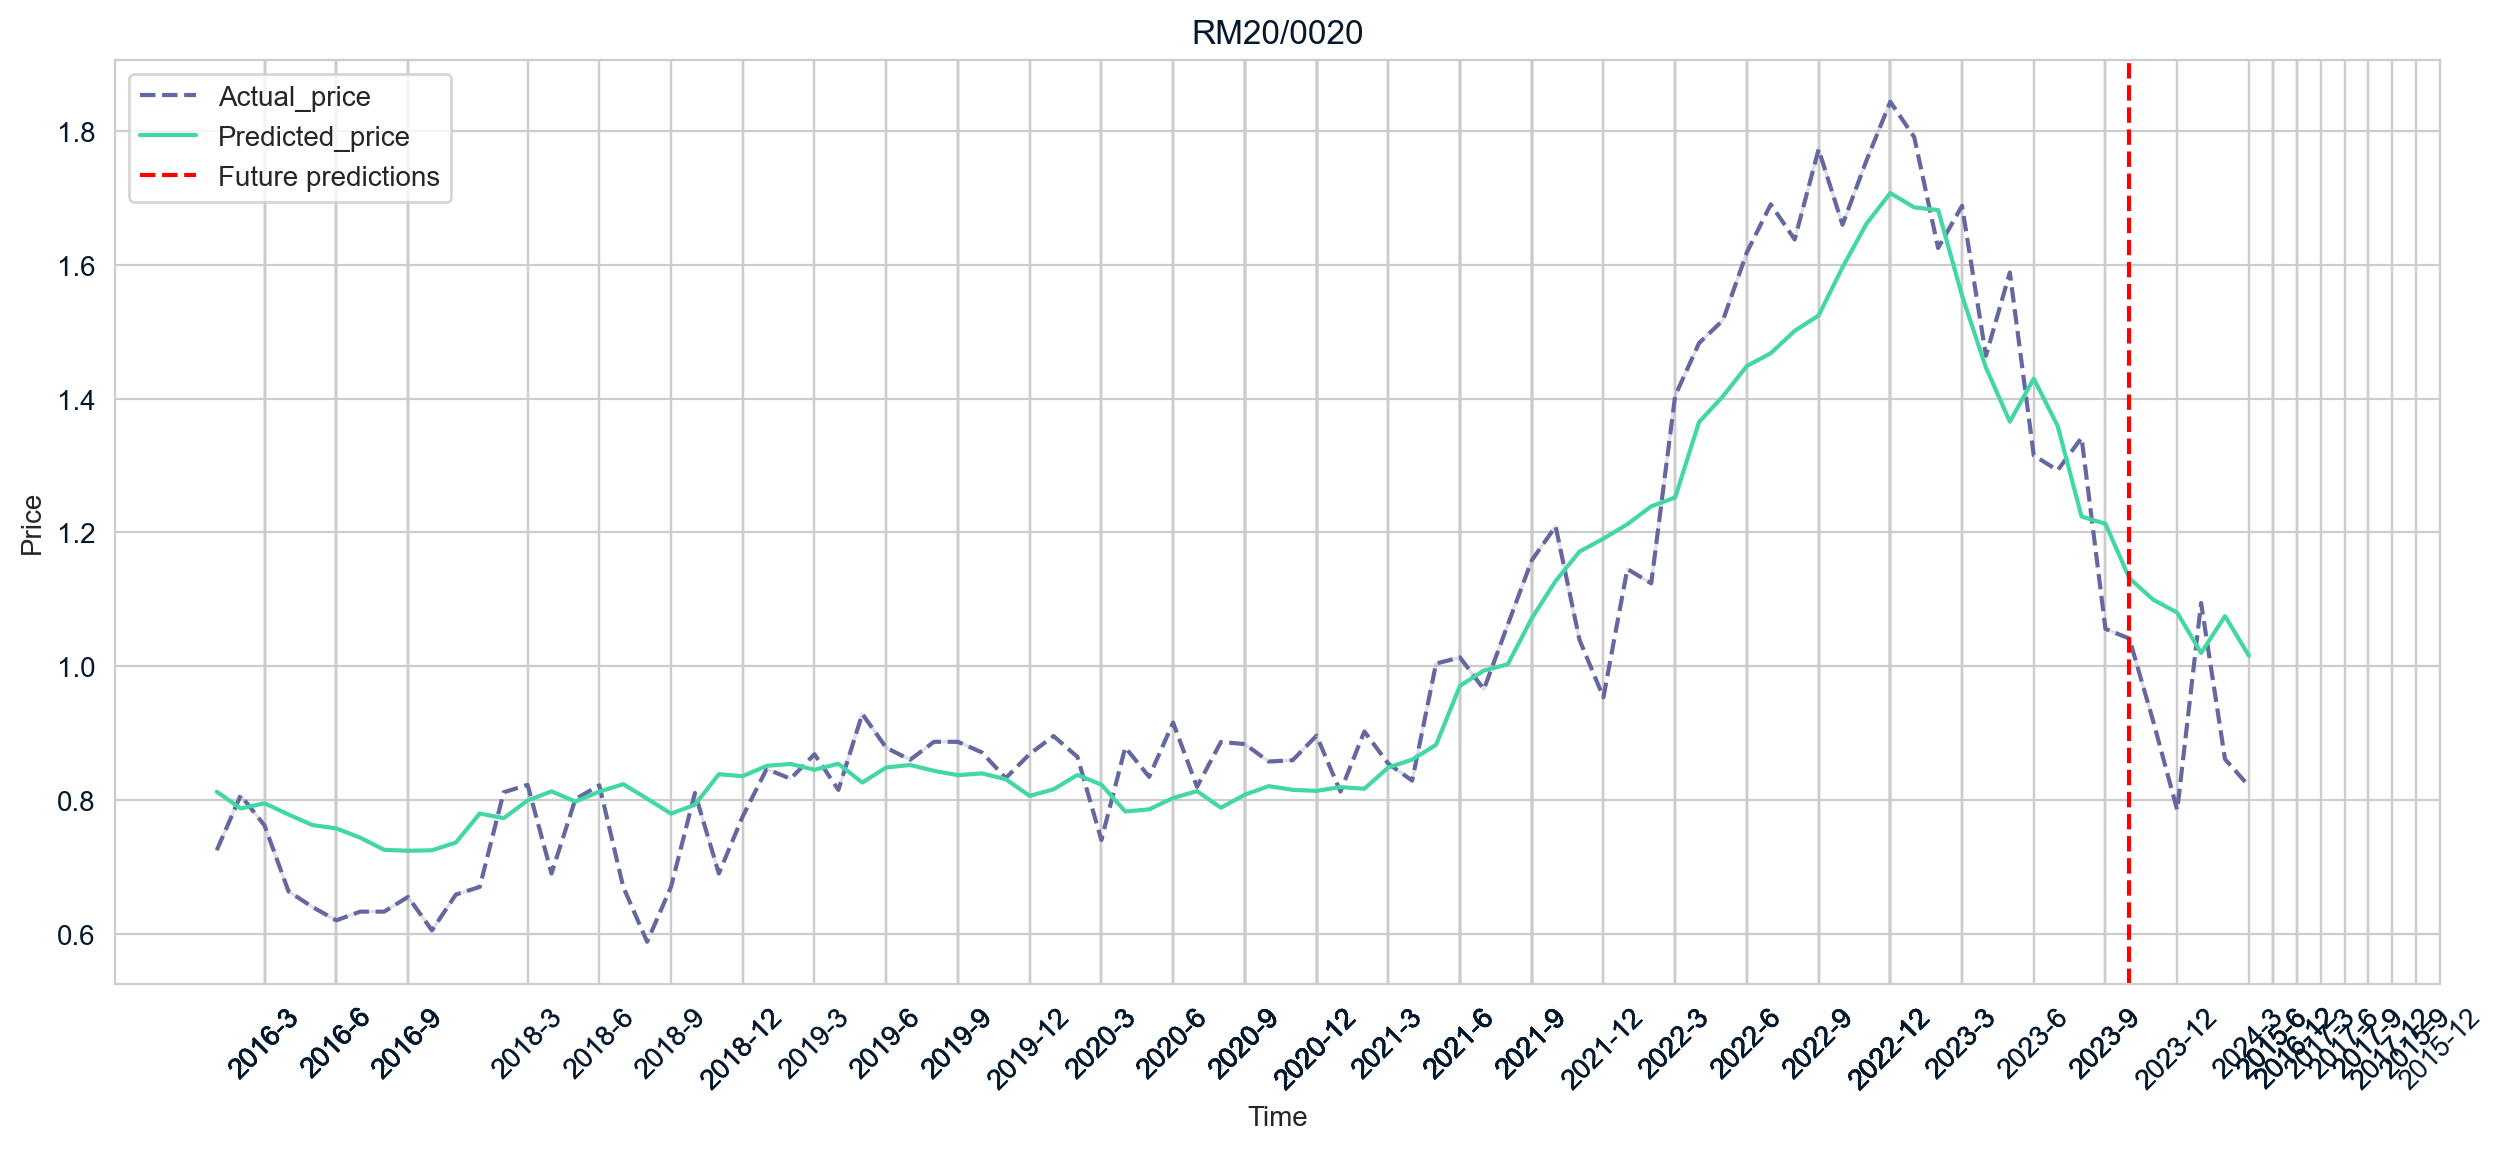

In [9]:
## Visualisation
# To match the predicted values with original df
target_df_24['Predictions'] = y_pred_24_inverse

target_df_24['year_month'] = target_df_24['Year'].apply(round).astype('str') + "-" + target_df_24['Month'].apply(round).astype('str')

# Visualisation
visual.draw_graph(target_df_24,'year_month','Average_price','Predictions','2023-10',*RM_codes)

## 3 months predictions

### Naive 3-month

MAPE of 3 month(s) builder Naive Forecast: 0.097
MSE of 3 month(s) builder Naive Forecast: 0.067


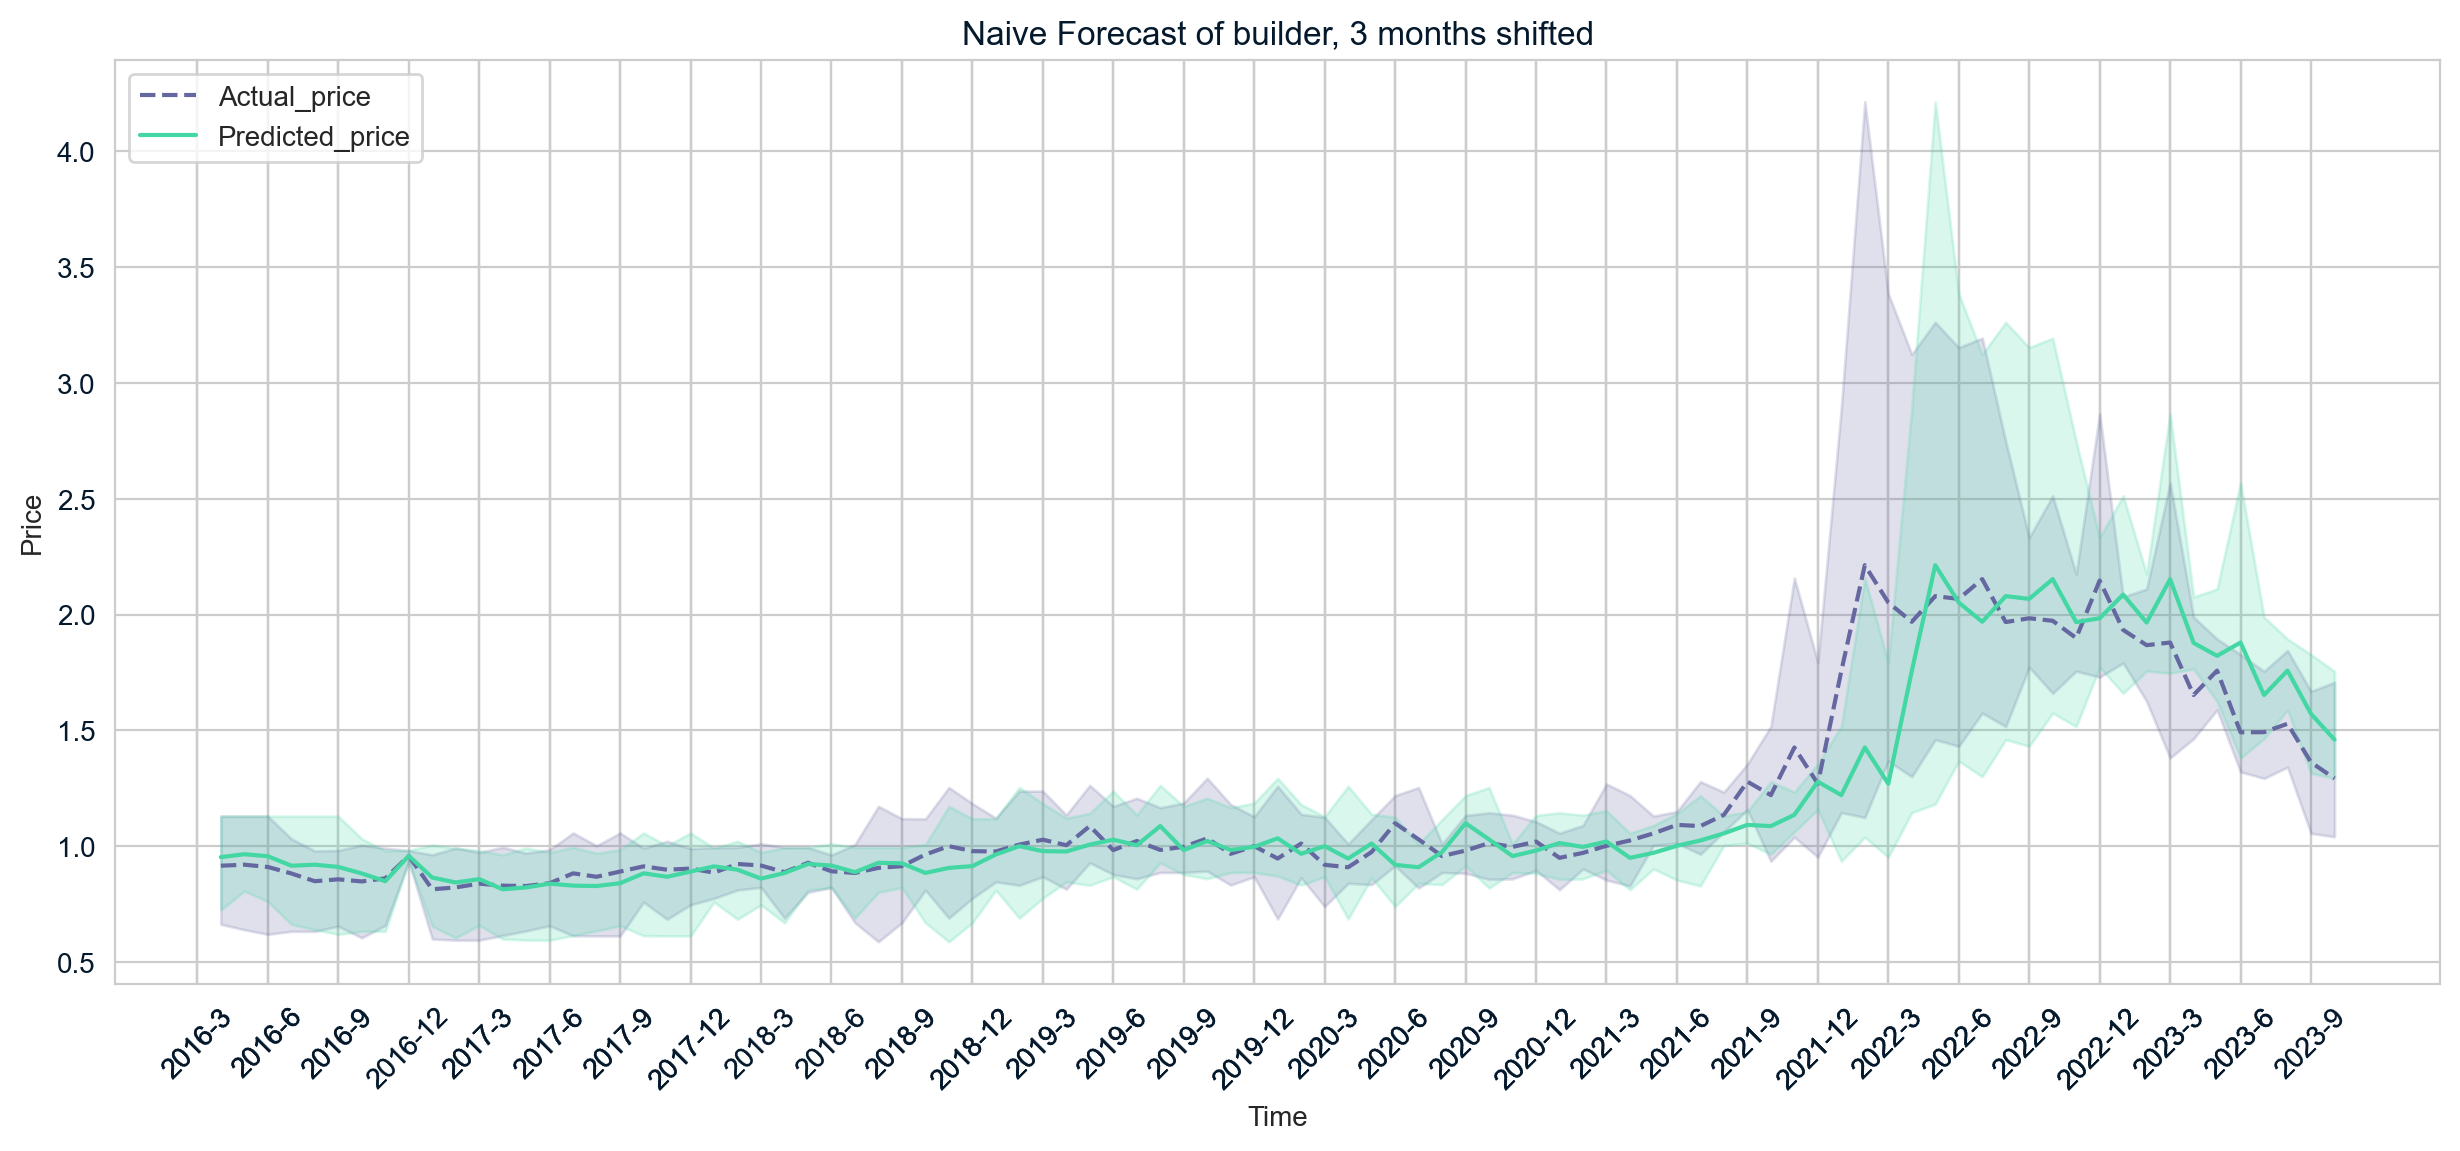

In [10]:
# Naive forecast
nf.naive_forest(naive_df,target,3,missing)

### Lasso 3-month

In [11]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Slice data for 3-month lag
try:
    for feature in slicing_columns:
         target_df=target_df.drop([f"{feature}_{i}" for i in range(1,3)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2" )) for col in target_df.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")

# Create X, y
feature_list = target_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = target_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [12]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

print("MAPE, 3-month, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))
print("MSE, 3-month, train: ", round(mean_squared_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 0.004668322274091364
Best R-squared score: 0.879
Coefficients of the selected features in the best Lasso model:
RM20/0015: -0.142
RM20/0020: -0.331
Electricity_3: 0.0
WPU01130232_3: -0.0
PMAIZMTUSDM_3: 0.105
WPU07110224_3: -0.0
WPU065202_3: 0.0
Electricity_4: 0.005
WPU01130232_4: -0.0
PMAIZMTUSDM_4: 0.014
WPU07110224_4: 0.0
WPU065202_4: 0.083
Electricity_5: -0.015
WPU01130232_5: -0.0
PMAIZMTUSDM_5: 0.01
WPU07110224_5: 0.065
WPU065202_5: 0.0
Electricity_6: -0.0
WPU01130232_6: -0.008
PMAIZMTUSDM_6: 0.0
WPU07110224_6: 0.019
WPU065202_6: 0.034
Electricity_7: -0.0
WPU01130232_7: -0.038
PMAIZMTUSDM_7: 0.0
WPU07110224_7: 0.0
WPU065202_7: 0.0
Electricity_8: -0.002
WPU01130232_8: -0.0
PMAIZMTUSDM_8: 0.231
WPU07110224_8: 0.0
WPU065202_8: 0.0
Electricity_9: -0.046
WPU01130232_9: 0.0
PMAIZMTUSDM_9: 0.0
WPU07110224_9: -0.0
WPU065202_9: -0.0
Electricity_10: -0.0
WPU01130232_10: -0.0
PMAIZMTUSDM_10: 0.053
WPU07110224_10: -0.0
WPU065202_10: -0.0
Electricity_11: -0.0
WPU01130232_1

In [13]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 3-month, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

# Best mean_squared_error
print("MSE, 3-month, test: ", round(mean_squared_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.004668322274091364)
Test Set R-squared score: 0.863
MAPE, 3-month, test:  0.091
MSE, 3-month, test:  0.034


In [14]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

df_24 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2014,2024)

imputed_df_24, missing_24 = pre.impute_pred_price_evo_csv(df_24)

dummy_df_24 = pre.get_dummies_and_average_price(imputed_df_24,target,*RM_codes)

target_df_24 = pre.generate_features(1,12,dummy_df_24,*RM_codes,**external_drivers)

# Slice data for 3-month lag
try:
    for feature in slicing_columns:
         target_df_24=target_df_24.drop([f"{feature}_{i}" for i in range(1,3)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2" )) for col in target_df_24.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")


# Create X, y
feature_list = target_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list
y_24 = target_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f"MAPE, 3-month, new data: {mape_24:.3f}")
mse_24 = mean_squared_error(y_24,y_pred_24_inverse)
# Best mean_squared_error
print(f"MSE, 3-month, new data: {mse_24:.3f}")

MAPE, 3-month, new data: 0.085
MSE, 3-month, new data: 0.036


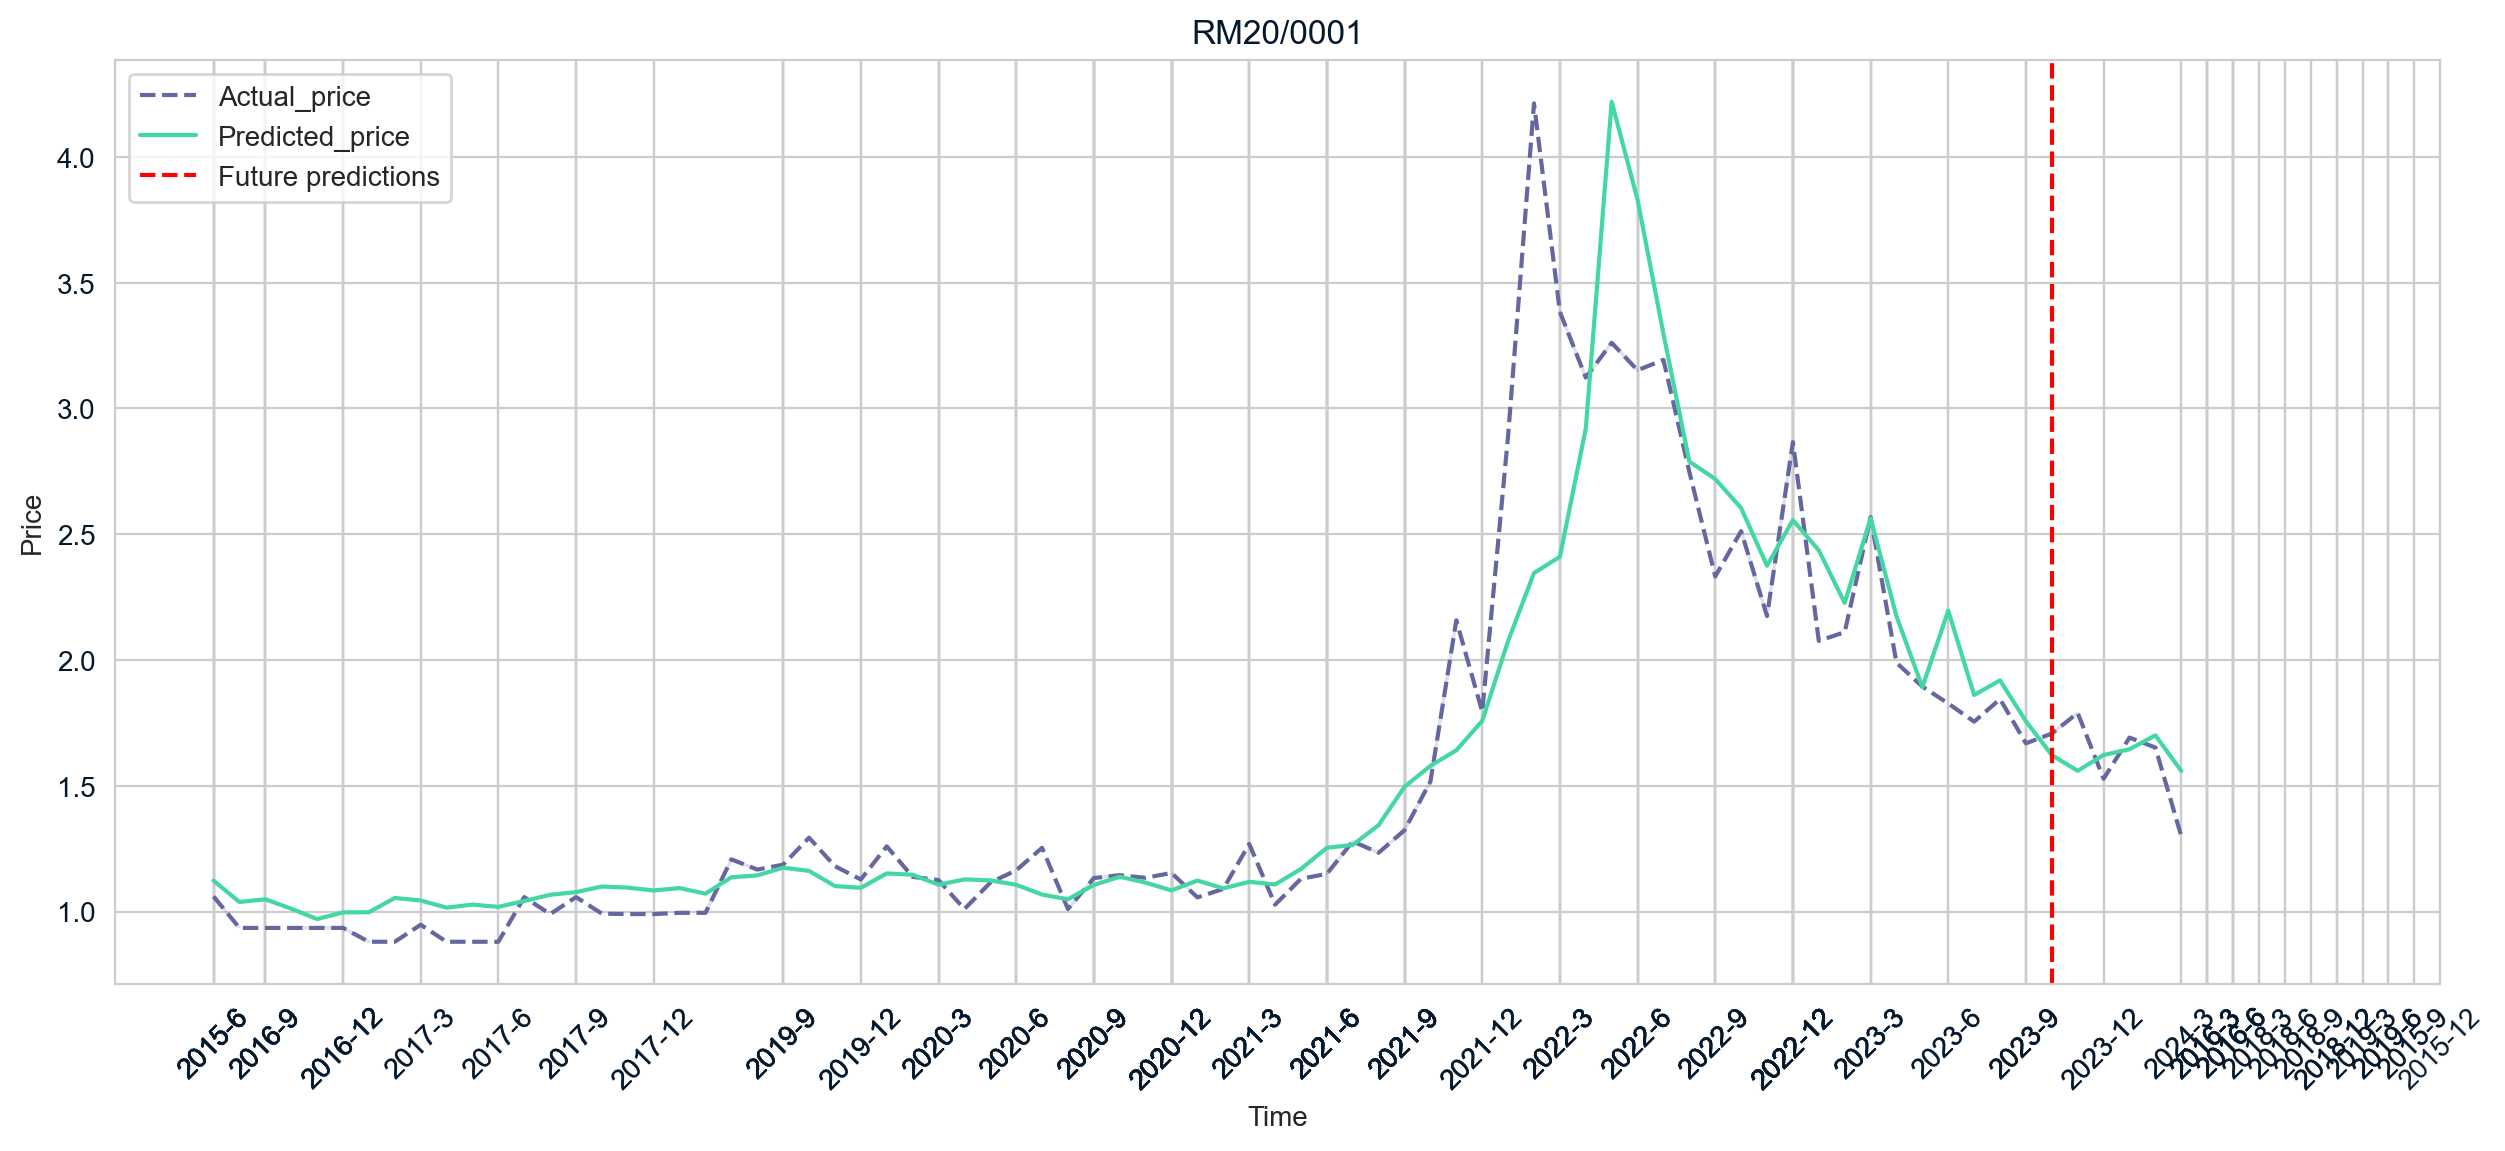

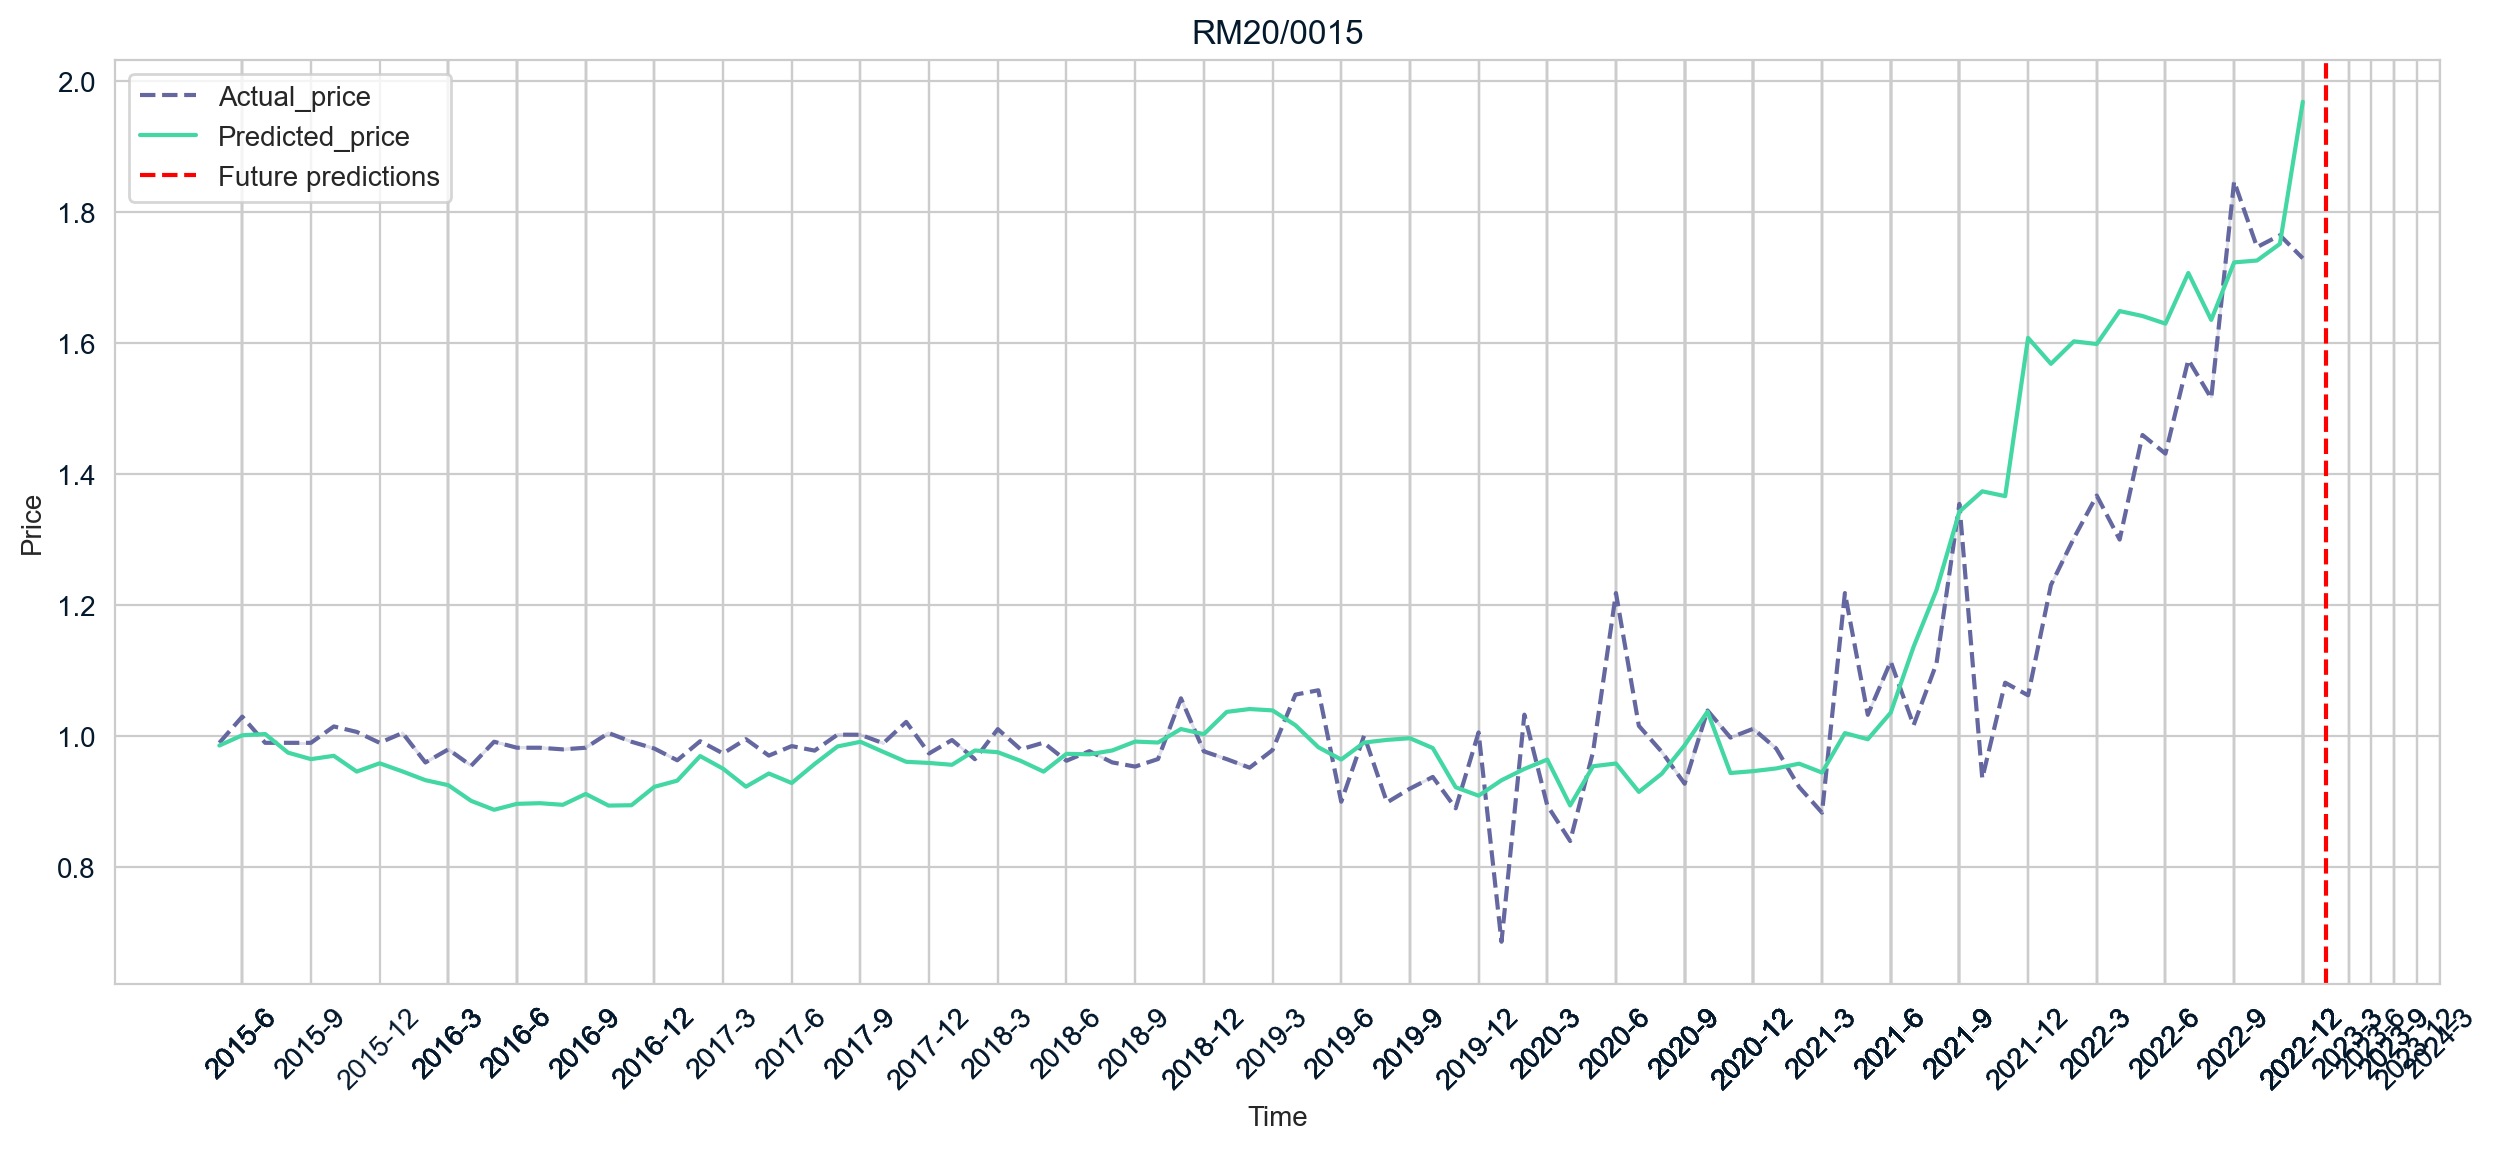

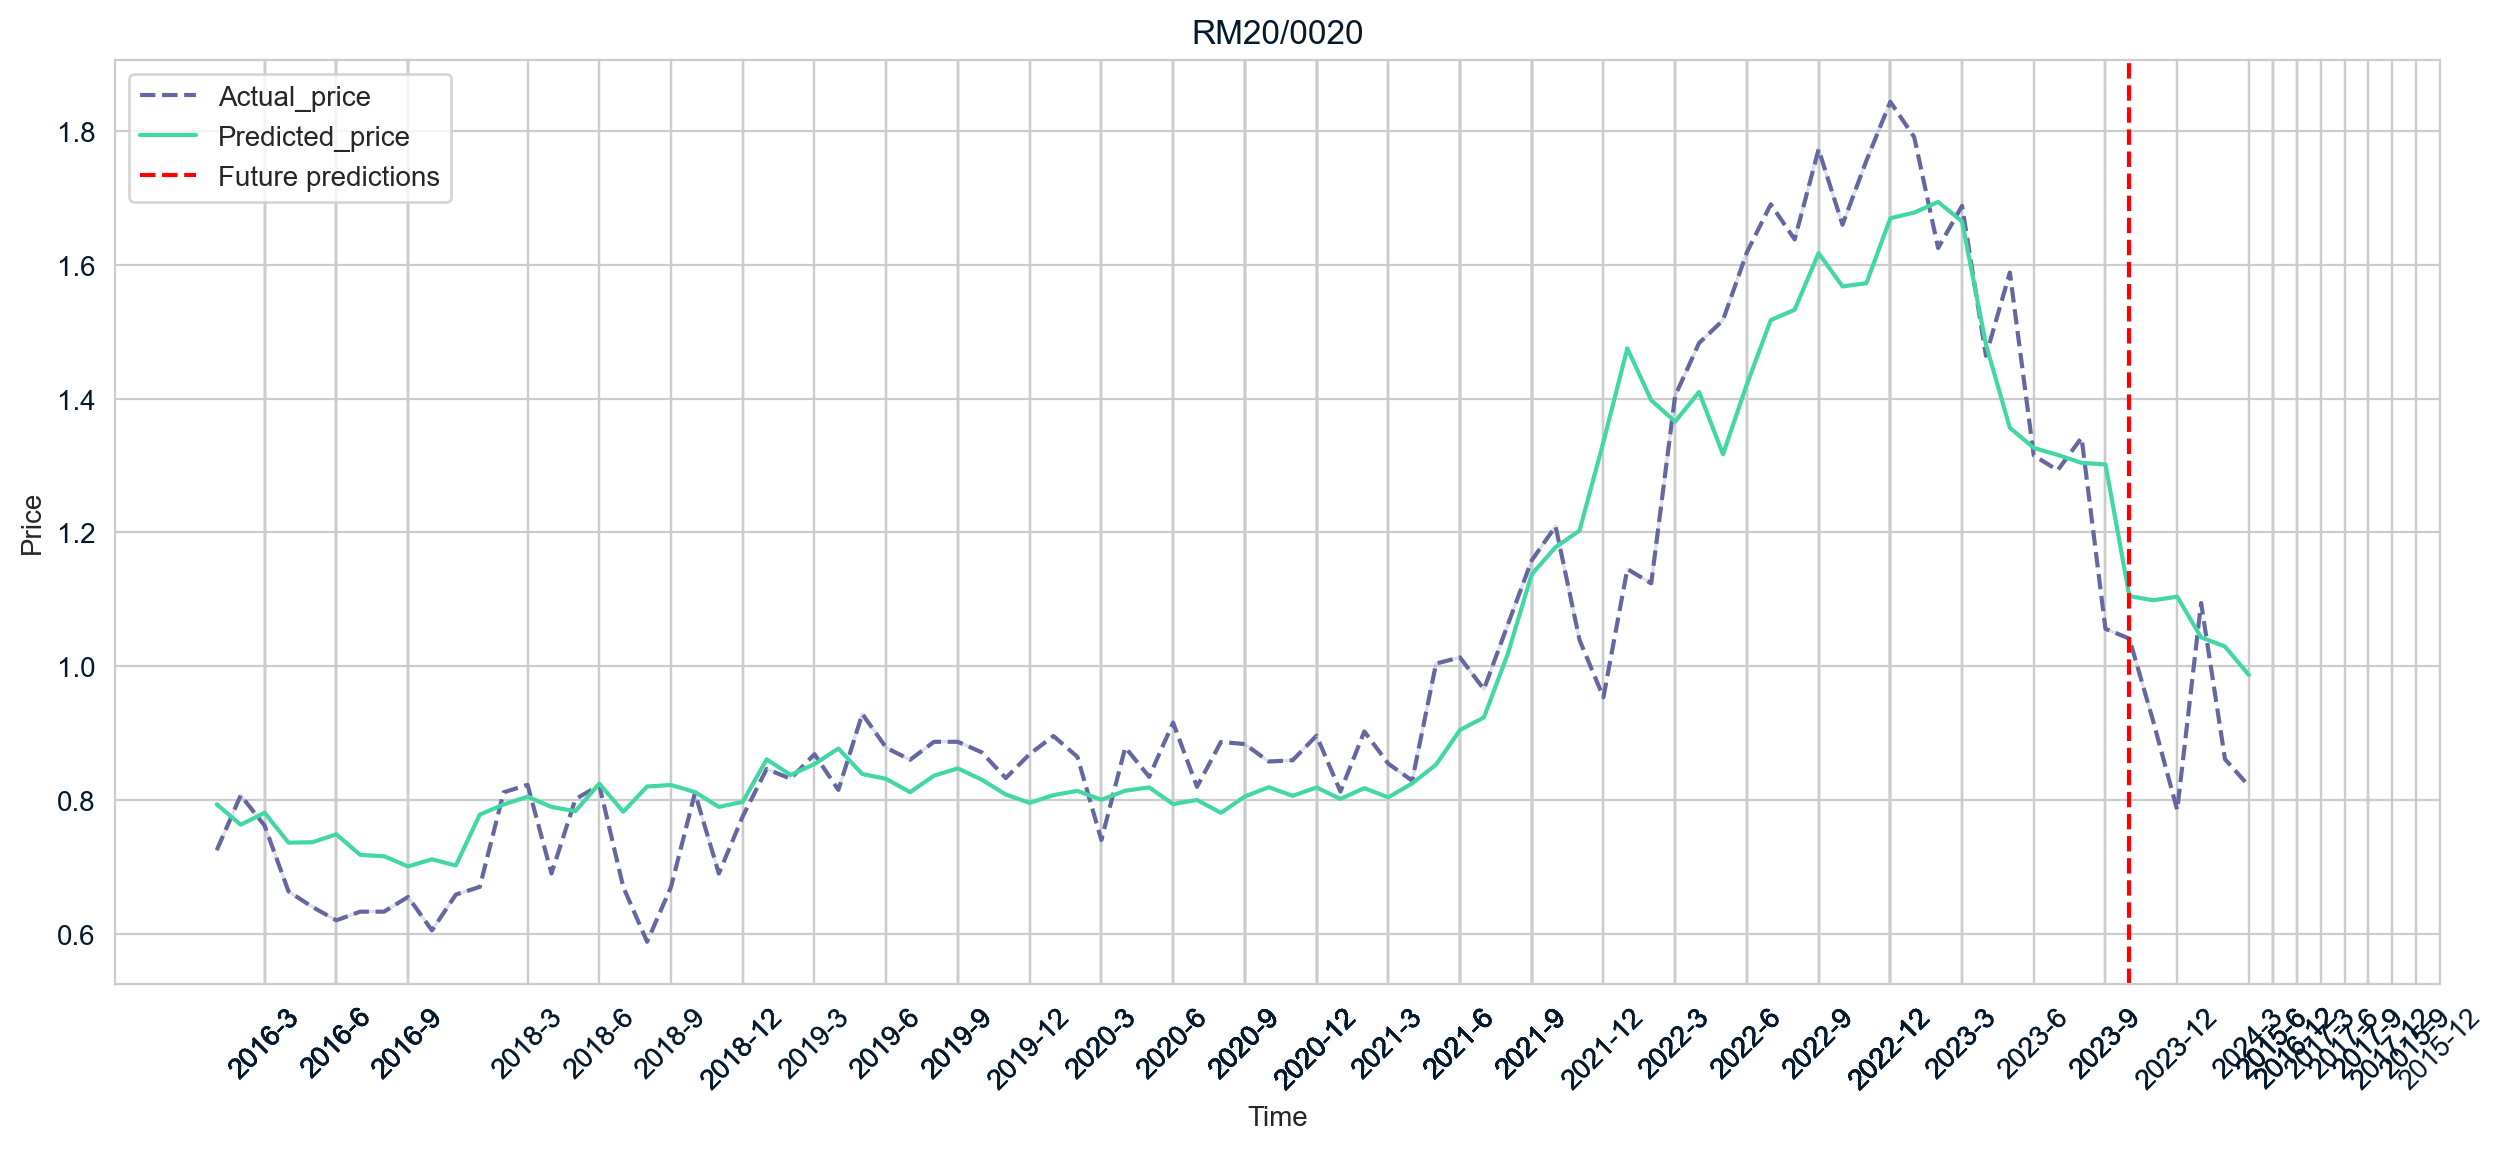

In [15]:
## Visualisation
# To match the predicted values with original df
target_df_24['Predictions'] = y_pred_24_inverse

target_df_24['year_month'] = target_df_24['Year'].apply(round).astype('str') + "-" + target_df_24['Month'].apply(round).astype('str')

# Visualisation
visual.draw_graph(target_df_24,'year_month','Average_price','Predictions','2023-10',*RM_codes)

## 6-month prediction

### Naive 6-month

MAPE of 6 month(s) builder Naive Forecast: 0.133
MSE of 6 month(s) builder Naive Forecast: 0.154


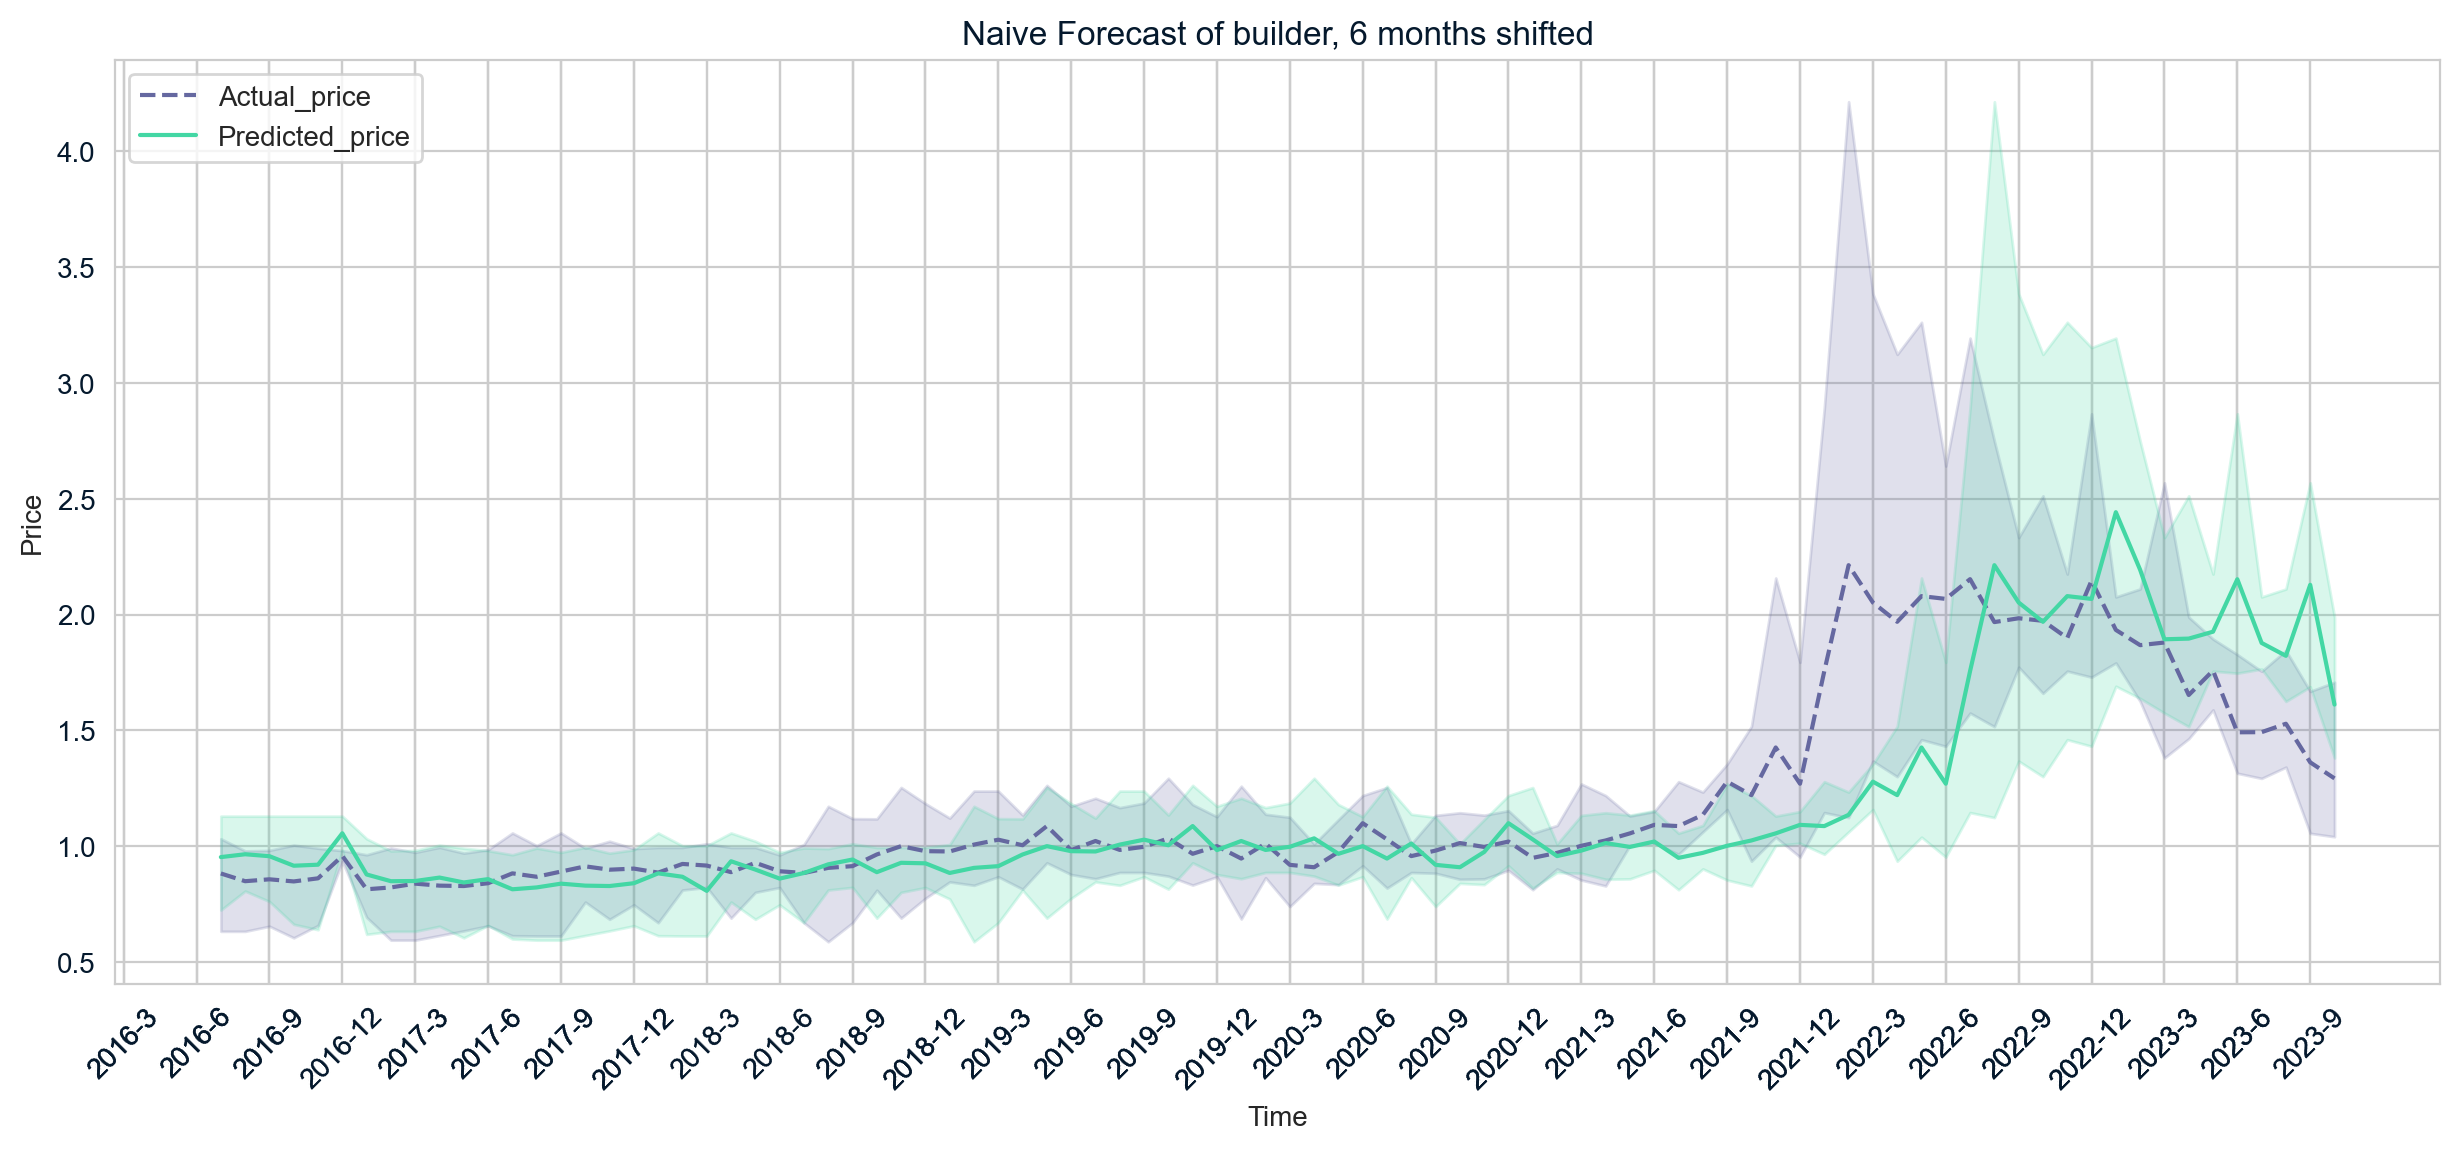

In [16]:
# Naive forecast
nf.naive_forest(naive_df,target,6,missing)

### Lasso 6-month

In [17]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Slice data for 6-month lag
try:
    for feature in slicing_columns:
         target_df=target_df.drop([f"{feature}_{i}" for i in range(1,6)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5" )) for col in target_df.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")
    
# Create X, y
feature_list = target_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = target_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [18]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

print("MAPE, 6-month, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))
print("MSE, 6-month, train: ", round(mean_squared_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 0.010003433444481492
Best R-squared score: 0.845
Coefficients of the selected features in the best Lasso model:
RM20/0015: -0.211
RM20/0020: -0.446
Electricity_6: 0.0
WPU01130232_6: -0.033
PMAIZMTUSDM_6: 0.114
WPU07110224_6: 0.0
WPU065202_6: 0.284
Electricity_7: -0.0
WPU01130232_7: -0.035
PMAIZMTUSDM_7: 0.0
WPU07110224_7: 0.0
WPU065202_7: 0.0
Electricity_8: -0.0
WPU01130232_8: -0.0
PMAIZMTUSDM_8: 0.162
WPU07110224_8: 0.0
WPU065202_8: 0.0
Electricity_9: -0.007
WPU01130232_9: -0.006
PMAIZMTUSDM_9: 0.0
WPU07110224_9: 0.0
WPU065202_9: -0.0
Electricity_10: -0.0
WPU01130232_10: -0.02
PMAIZMTUSDM_10: 0.042
WPU07110224_10: 0.0
WPU065202_10: -0.0
Electricity_11: -0.0
WPU01130232_11: -0.0
PMAIZMTUSDM_11: 0.221
WPU07110224_11: 0.0
WPU065202_11: -0.0
Electricity_12: -0.124
WPU01130232_12: -0.031
PMAIZMTUSDM_12: 0.117
WPU07110224_12: 0.0
WPU065202_12: -0.172
AR_6: 0.203
AR_7: 0.0
AR_8: 0.0
AR_9: -0.05
AR_10: 0.0
AR_11: -0.0
AR_12: -0.01
MAPE, 6-month, train:  0.097
MSE, 6-mont

In [19]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 6-month, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

# Best mean_squared_error
print("MSE, 6-month, test: ", round(mean_squared_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=0.010003433444481492)
Test Set R-squared score: 0.803
MAPE, 6-month, test:  0.114
MSE, 6-month, test:  0.046


In [20]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

df_24 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2014,2024)

imputed_df_24, missing_24 = pre.impute_pred_price_evo_csv(df_24)

dummy_df_24 = pre.get_dummies_and_average_price(imputed_df_24,target,*RM_codes)

target_df_24 = pre.generate_features(1,12,dummy_df_24,*RM_codes,**external_drivers)

# Slice data for 6-month lag
try:
    for feature in slicing_columns:
         target_df_24=target_df_24.drop([f"{feature}_{i}" for i in range(1,6)], axis=1, errors='ignore')
    
    assert not any(col.endswith(("_1", "_2", "_3", "_4", "_5" )) for col in target_df_24.columns) , "df not sliced correctly"
except AssertionError:
    print("Unable to slice DataFrame")

    
# Create X, y
feature_list = target_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list
y_24 = target_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f"MAPE, 6-month, new data: {mape_24:.3f}")
mse_24 = mean_squared_error(y_24,y_pred_24_inverse)
# Best mean_squared_error
print(f"MSE, 6-month, new data: {mse_24:.3f}")

MAPE, 6-month, new data: 0.103
MSE, 6-month, new data: 0.051


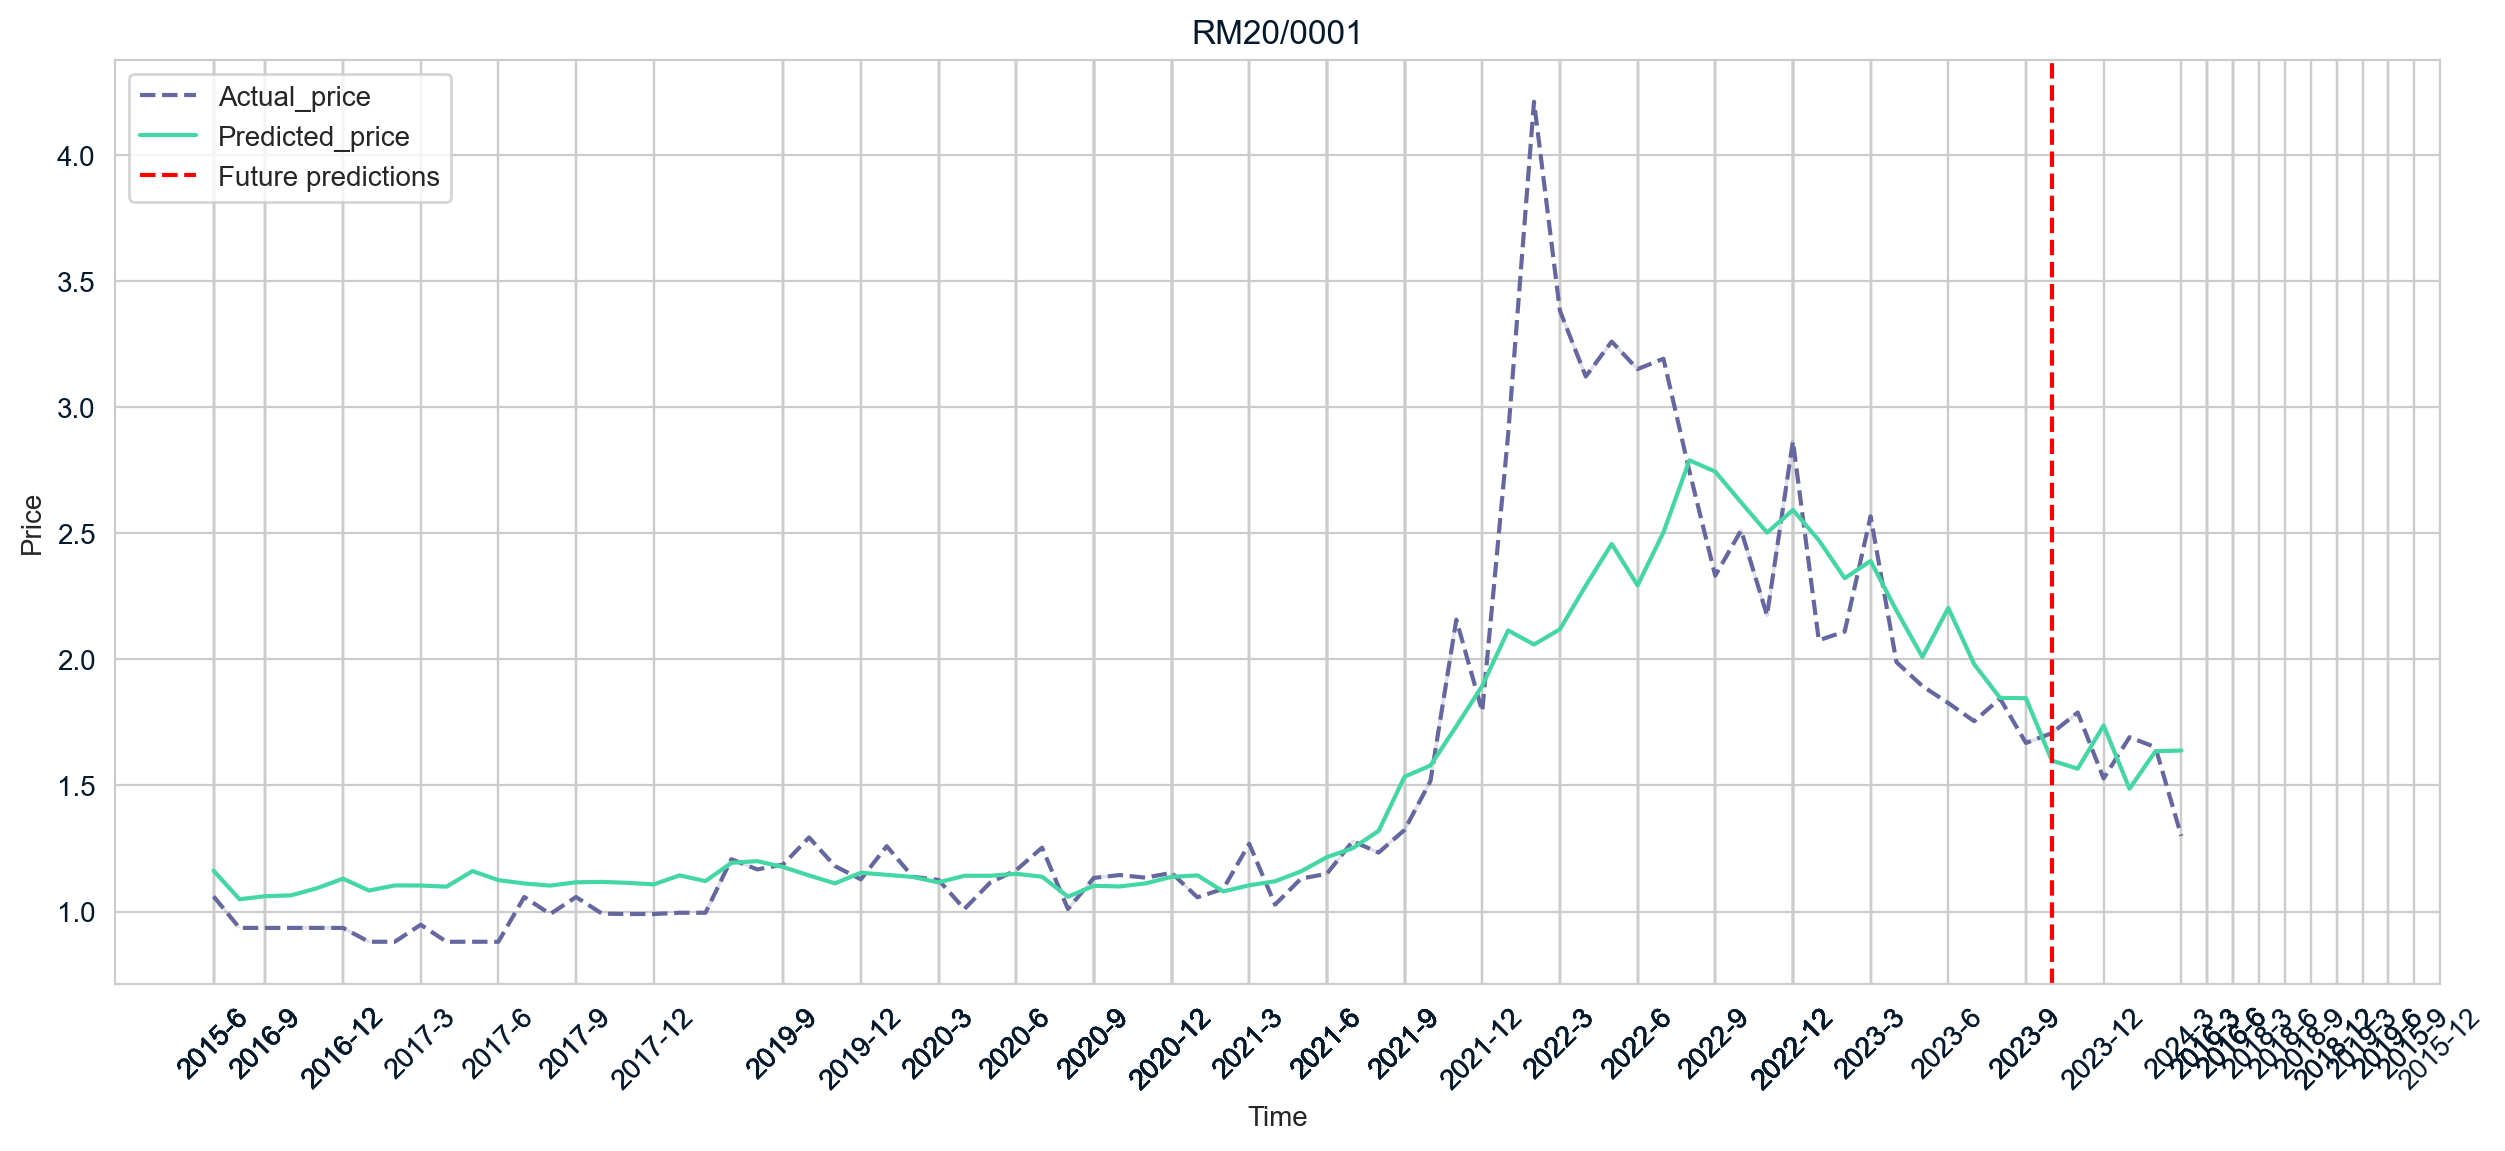

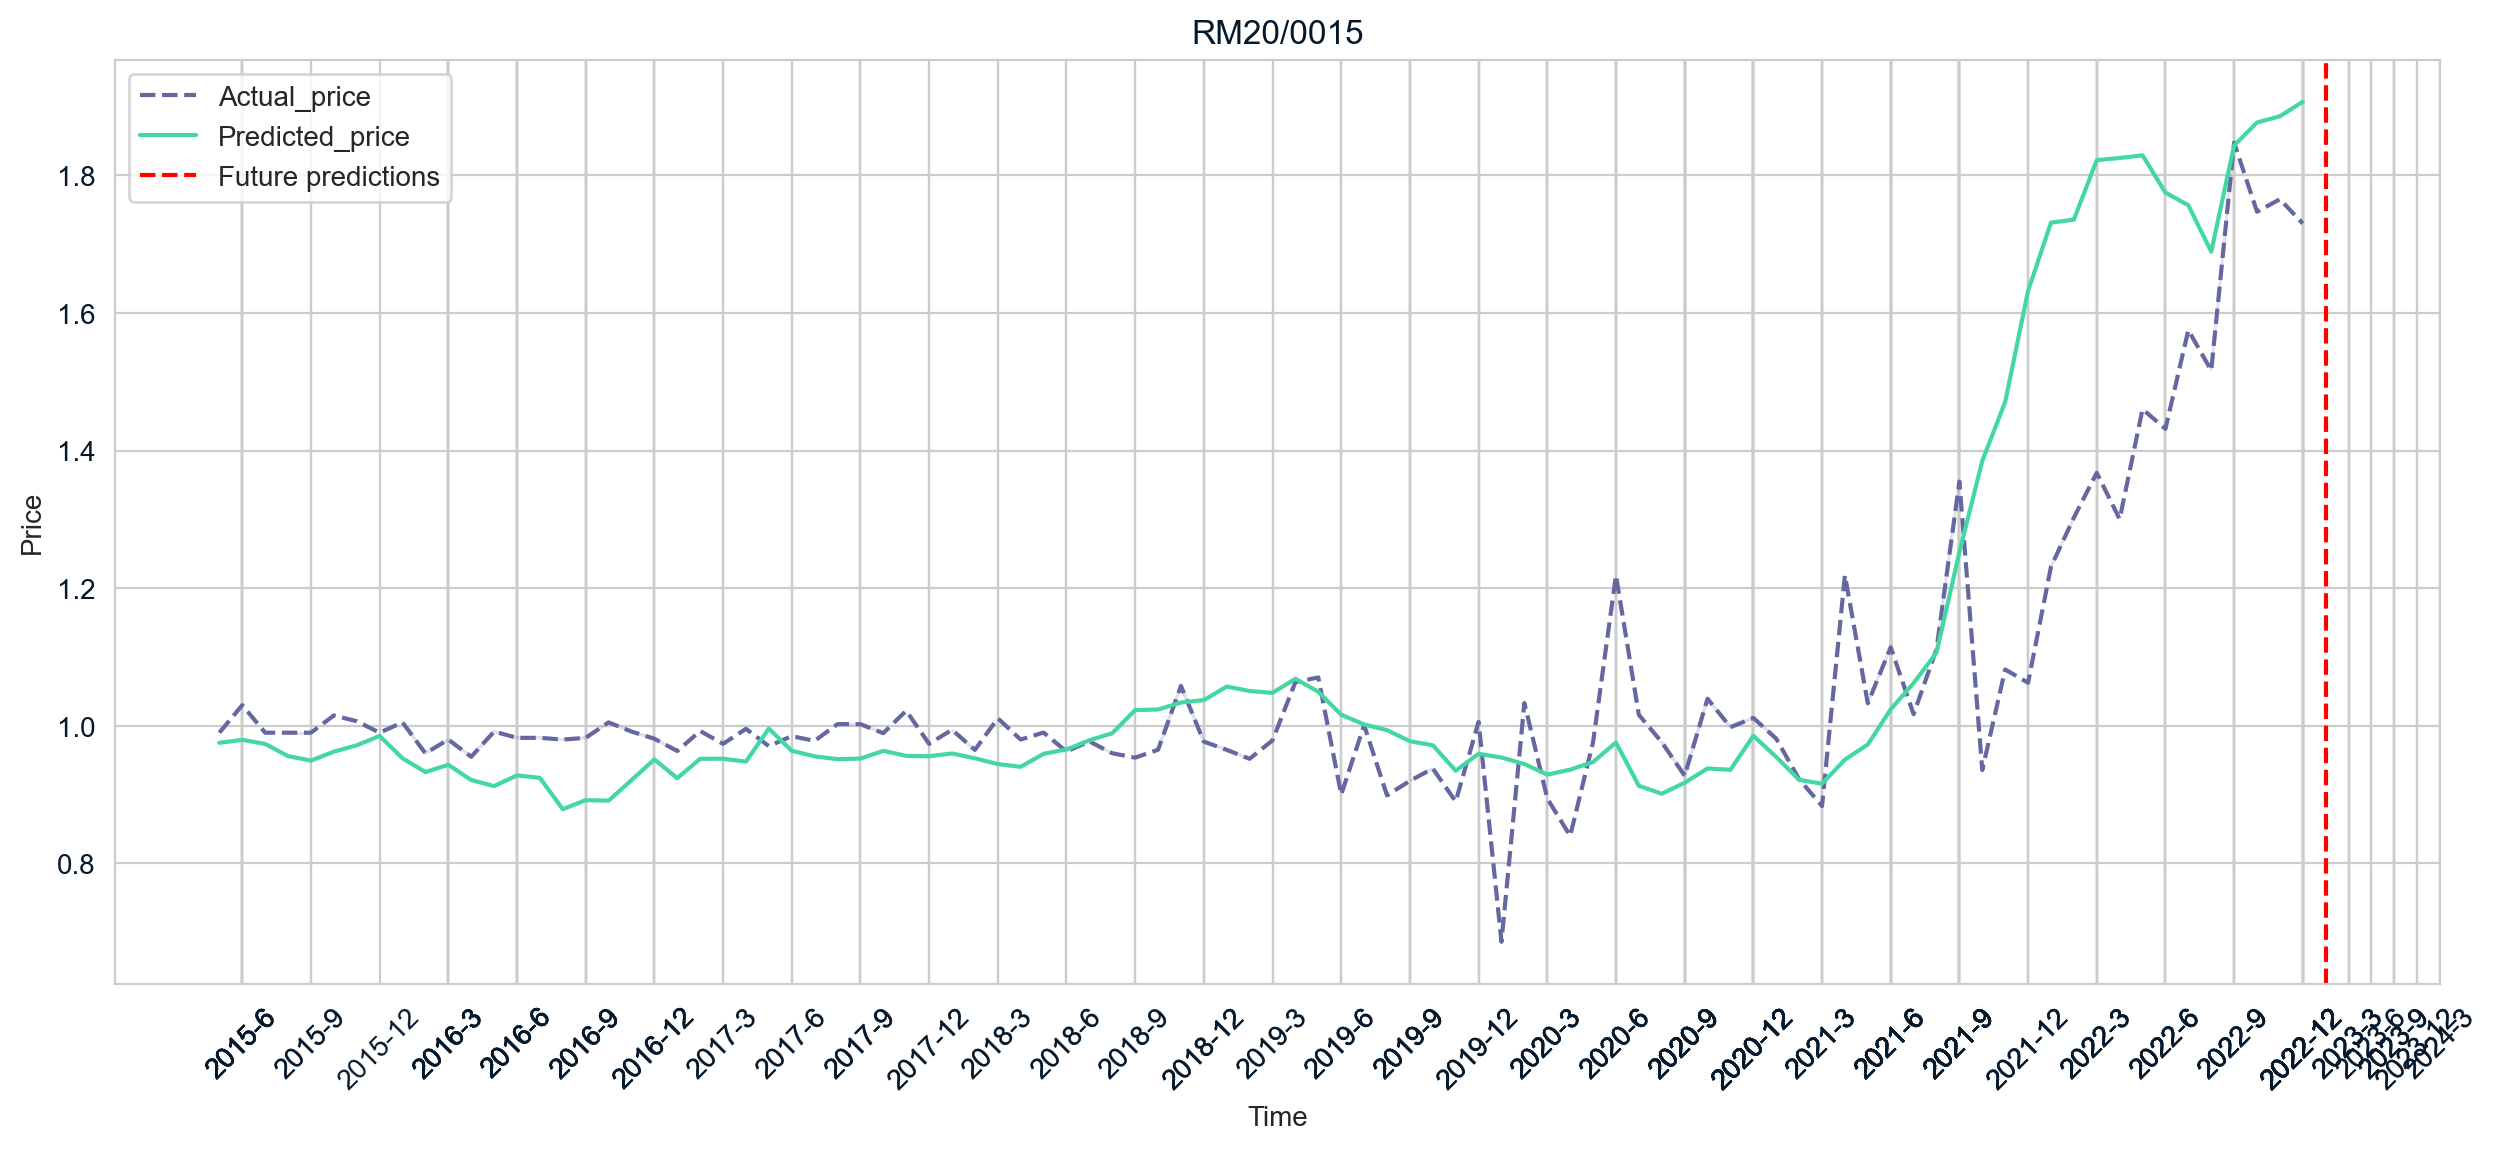

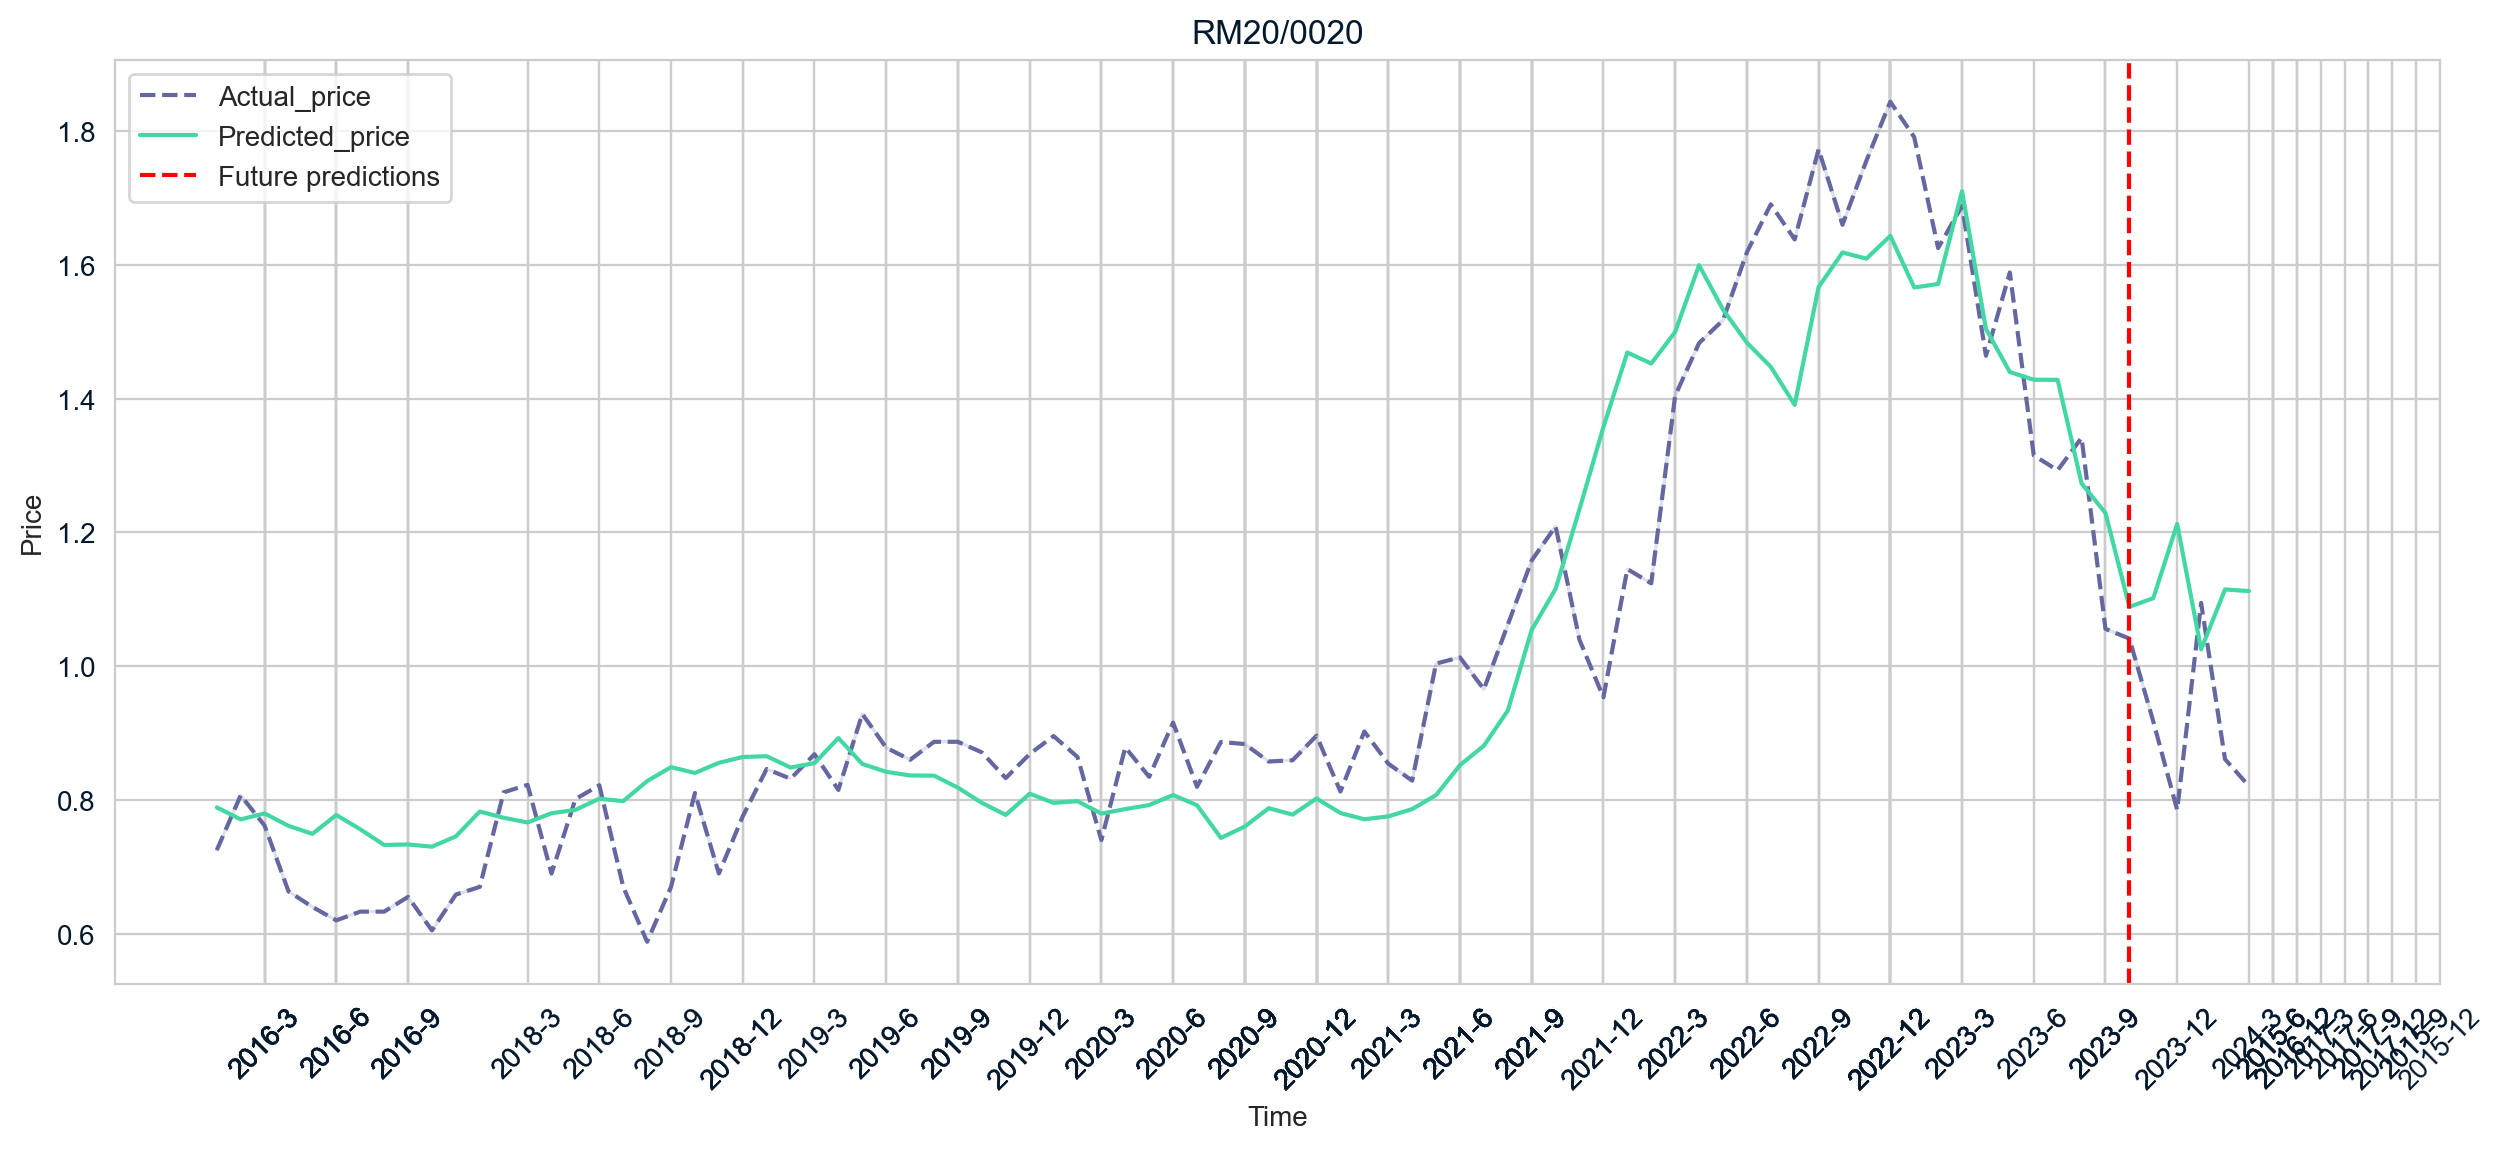

In [21]:
## Visualisation
# To match the predicted values with original df
target_df_24['Predictions'] = y_pred_24_inverse

target_df_24['year_month'] = target_df_24['Year'].apply(round).astype('str') + "-" + target_df_24['Month'].apply(round).astype('str')

# Visualisation
visual.draw_graph(target_df_24,'year_month','Average_price','Predictions','2023-10',*RM_codes)